In [144]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy, time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from scipy.stats import skew, boxcox, boxcox_llf

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)

In [145]:
data_path = 'data/'
df_train = pd.read_csv(data_path + '3rd-ml100marathon-midterm/train_data.csv')
df_train_orig = df_train.copy()
df_test = pd.read_csv(data_path + '3rd-ml100marathon-midterm/test_features.csv')

In [146]:
# 刪除離群值 total
df_train = df_train.drop(df_train[df_train.name == "TOTAL"].index)
df_train = df_train.drop(df_train[df_train.name == "THE TRAVEL AGENCY IN THE PARK"].index)

In [147]:
train_Y = df_train['poi'] # 將Y label 切出來
df_train = df_train.drop(['poi'] , axis=1) # 把 label 捨棄 
df = pd.concat([df_train, df_test])
df.reset_index(drop=True, inplace=True)
df.head()

name      bonus  deferral_payments  deferred_income  director_fees  \
0        RICE KENNETH D  1750000.0                NaN       -3504386.0            NaN   
1    SKILLING JEFFREY K  5600000.0                NaN              NaN            NaN   
2            SHELBY REX   200000.0                NaN          -4167.0            NaN   
3      KOPPER MICHAEL J   800000.0                NaN              NaN            NaN   
4  CALGER CHRISTOPHER F  1250000.0                NaN        -262500.0            NaN   

                  email_address  exercised_stock_options  expenses  from_messages  \
0            ken.rice@enron.com               19794175.0   46950.0           18.0   
1       jeff.skilling@enron.com               19250000.0   29336.0          108.0   
2          rex.shelby@enron.com                1624396.0   22884.0           39.0   
3      michael.kopper@enron.com                      NaN  118134.0            NaN   
4  christopher.calger@enron.com                      NaN   35818.0          144.0   

   from_poi_to_this_person  from_this_person_to_poi  loan_advances  long_term_incentive  \
0                     42.0                      4.0            NaN            1617011.0   
1                     88.0                     30.0            NaN            1920000.0   
2                     13.0                     14.0            NaN                  NaN   
3                      NaN                      NaN            NaN             602671.0   
4                    199.0                     25.0            NaN             375304.0   

       other  restricted_stock  restricted_stock_deferred     salary  shared_receipt_with_poi  \
0   174839.0         2748364.0                        NaN   420636.0                    864.0   
1    22122.0         6843672.0                        NaN  1111258.0                   2042.0   
2  1573324.0          869220.0                        NaN   211844.0                     91.0   
3   907502.0          985032.0                        NaN   224305.0                      NaN   
4      486.0          126027.0                        NaN   240189.0                   2188.0   

   to_messages  total_payments  total_stock_value  
0        905.0        505050.0         22542539.0  
1       3627.0       8682716.0         26093672.0  
2        225.0       2003885.0          2493616.0  
3          NaN       2652612.0           985032.0  
4       2598.0       1639297.0           126027.0

In [148]:
df_train.dtypes
"""
name                          object

bonus                        float64
(Reflects annual cash incentives paid based upon company performance.  Also may include other retention payments.)

deferral_payments            float64
(Reflects distributions from a deferred compensation arrangement due to 
termination of employment or due to in-service withdrawals as per plan provisions.)

deferred_income              float64
(Reflects voluntary executive deferrals of salary, annual cash incentives,
and long-term cash incentives as well as cash fees deferred by non-employee directors 
under a deferred compensation arrangement.  
May also reflect deferrals under a stock option or phantom stock unit in lieu of cash arrangement.  )

director_fees                float64
(Reflects cash payments and/or value of stock grants made in lieu of cash payments to non-employee directors.  )

email_address                 object

exercised_stock_options      float64
(Reflects amounts from exercised stock options which equal the market value 
in excess of the exercise price on the date the options were exercised either through 
cashless (same-day sale), stock swap or cash exercises.  The reflected gain may differ 
from that realized by the insider due to fluctuations in the market price and 
the timing of any subsequent sale of the securities.)

expenses                     float64
(Reflects reimbursements of business expenses.  May include fees paid for consulting services.)

from_messages                float64
from_poi_to_this_person      float64
from_this_person_to_poi      float64

loan_advances                float64
(Reflects total amount of loan advances, excluding repayments, provided by the Debtor in return for a promise of repayment.  In certain instances, the terms of the 
promissory notes allow for the option to repay with stock of the company.)

long_term_incentive          float64
(Reflects long-term incentive cash payments from various long-term incentive programs designed to tie executive 
compensation to long-term success as measured against key performance drivers and business objectives 
over a multi-year period, generally 3 to 5 years.)

other                        float64
(Reflects items such as payments for severance, consulting services, relocation costs,
tax advances and allowances for employees on international assignment (i.e. 
housing allowances, cost of living allowances, payments under Enron’s Tax Equalization Program, etc.).  
May also include payments provided with respect to employment agreements,
as well as imputed income amounts for such things as use of corporate aircraft. )

poi                             bool

restricted_stock             float64
限制性股票是指上市公司按照股權激勵計劃約定的條件，
授予公司員工一定數量本公司的股票。激勵對像只有在年限工作或業績目標符合股權激勵計劃規定條件的，才可出售限制性股票並從中獲益。
(Reflects the gross fair market value of shares and accrued dividends (and/or phantom units and dividend equivalents) 
on the date of release due to lapse of vesting periods, regardless of whether deferred.)

restricted_stock_deferred    float64
(Reflects value of restricted stock voluntarily deferred prior to release under a deferred compensation arrangement. )

salary                       float64 
(Reflects items such as base salary, executive cash allowances, and benefits payments.)

shared_receipt_with_poi      float64
to_messages                  float64
total_payments               float64
total_stock_value            float64
"""

'\nname                          object\n\nbonus                        float64\n(Reflects annual cash incentives paid based upon company performance.  Also may include other retention payments.)\n\ndeferral_payments            float64\n(Reflects distributions from a deferred compensation arrangement due to \ntermination of employment or due to in-service withdrawals as per plan provisions.)\n\ndeferred_income              float64\n(Reflects voluntary executive deferrals of salary, annual cash incentives,\nand long-term cash incentives as well as cash fees deferred by non-employee directors \nunder a deferred compensation arrangement.  \nMay also reflect deferrals under a stock option or phantom stock unit in lieu of cash arrangement.  )\n\ndirector_fees                float64\n(Reflects cash payments and/or value of stock grants made in lieu of cash payments to non-employee directors.  )\n\nemail_address                 object\n\nexercised_stock_options      float64\n(Reflects amounts

In [149]:
# 觀看原始資料中 T / Y的比例
"""
False    0.884956
True     0.115044
"""
df_train_orig['poi'].value_counts(normalize=True)

False    0.884956
True     0.115044
Name: poi, dtype: float64

In [150]:
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

19 Numeric Features : ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value']



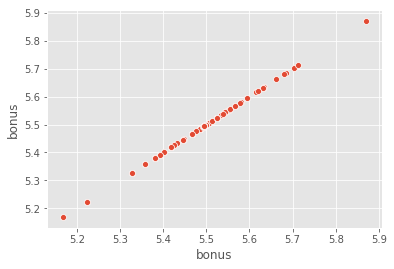

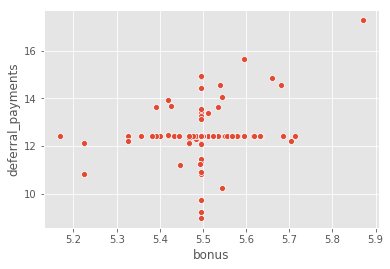

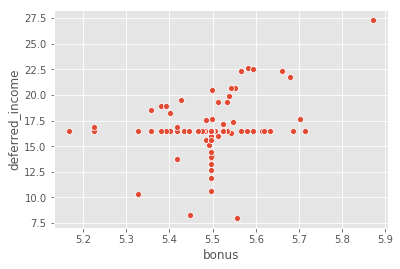

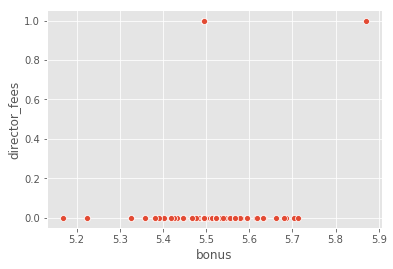

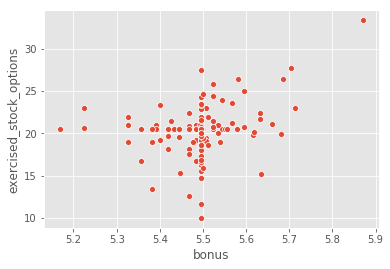

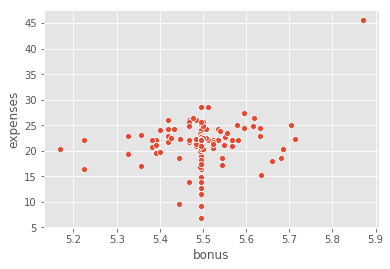

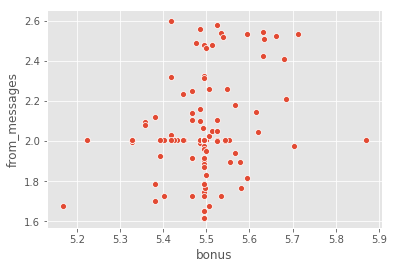

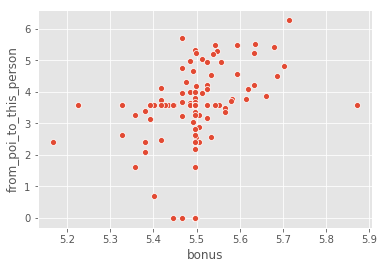

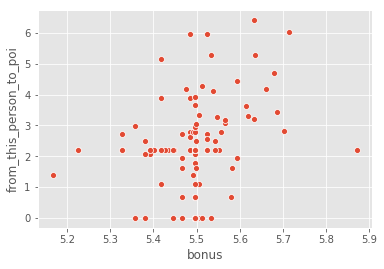

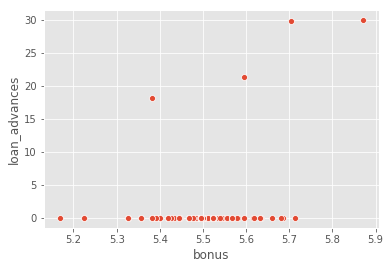

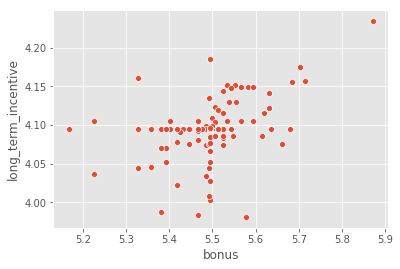

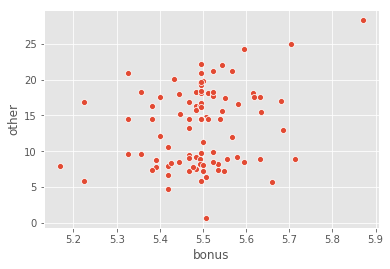

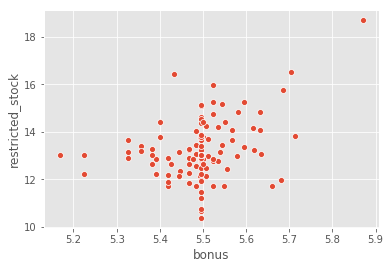

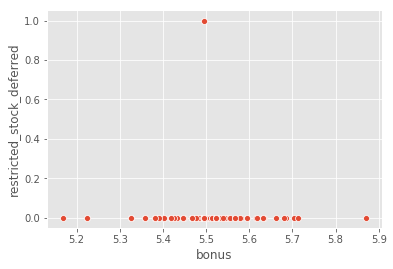

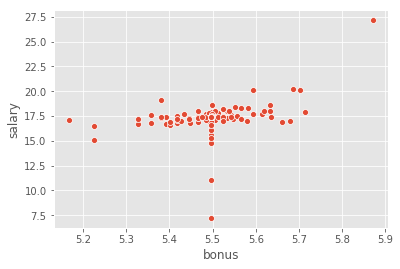

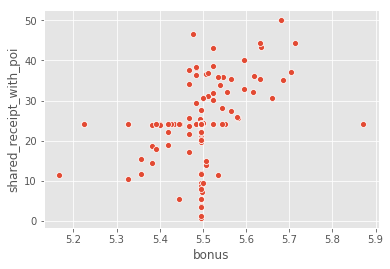

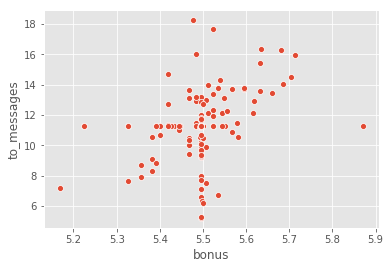

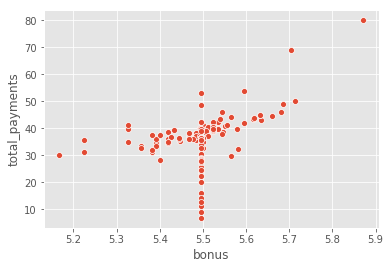

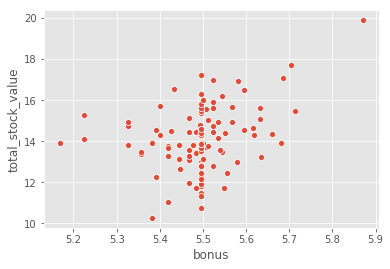

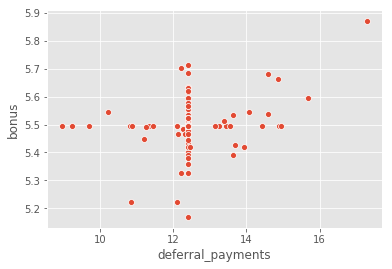

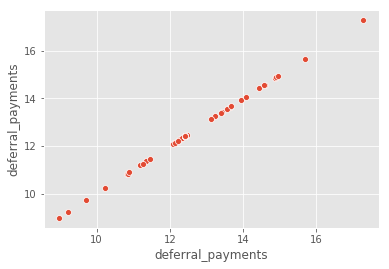

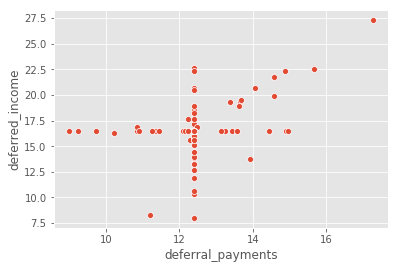

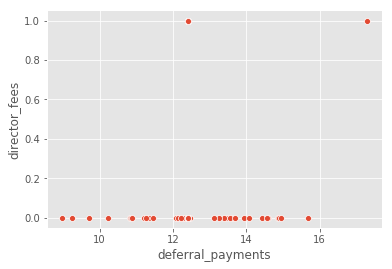

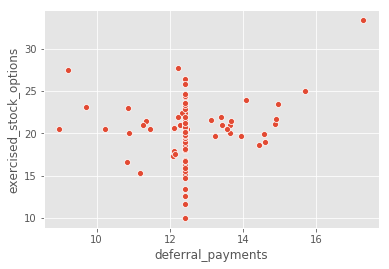

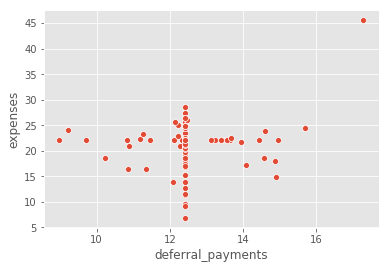

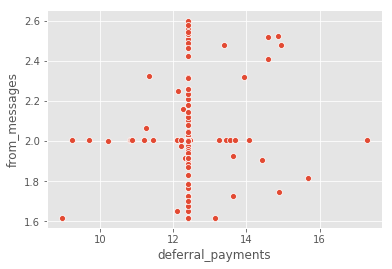

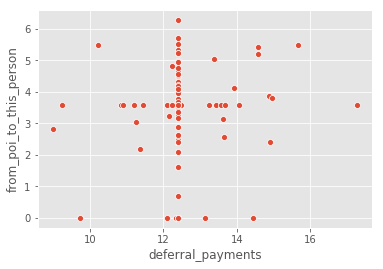

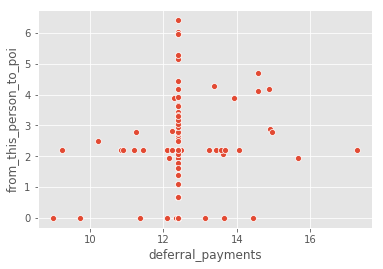

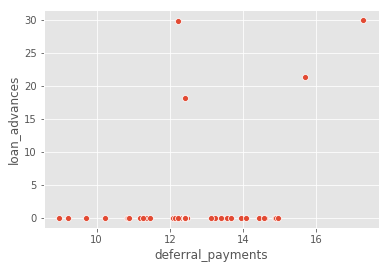

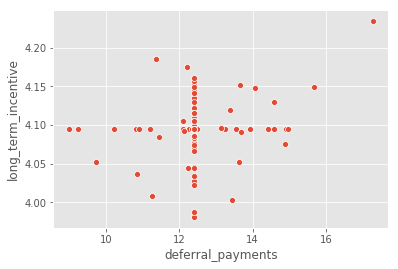

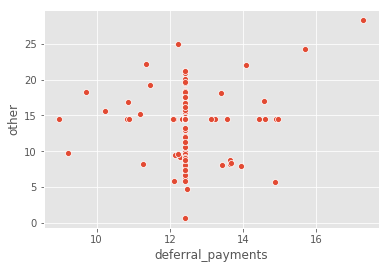

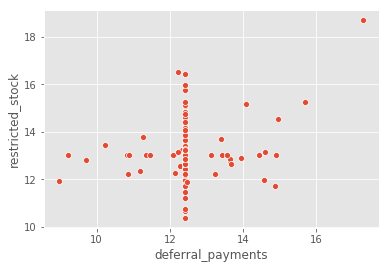

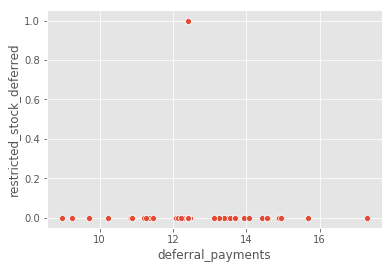

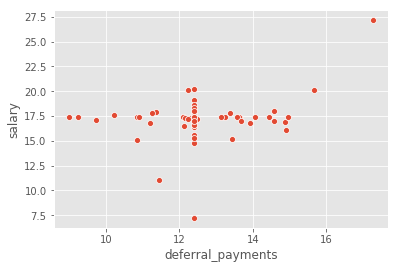

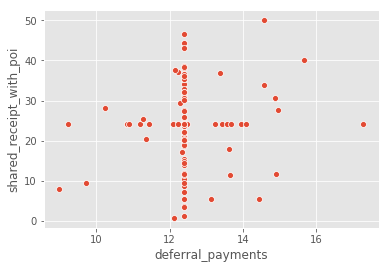

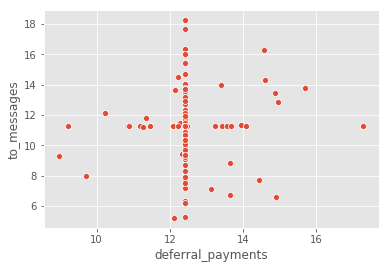

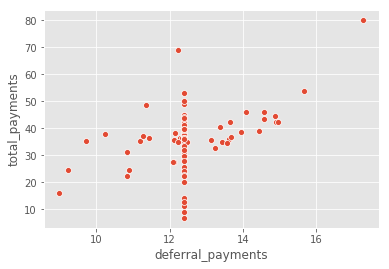

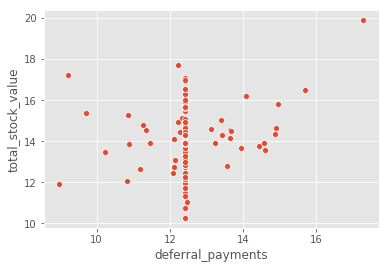

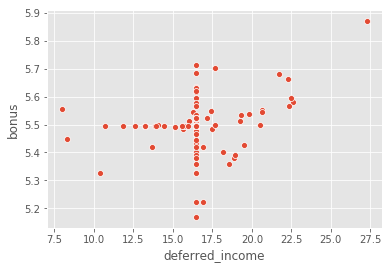

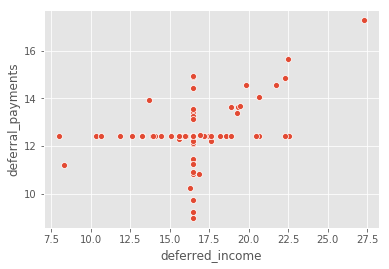

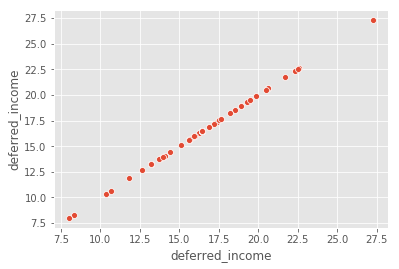

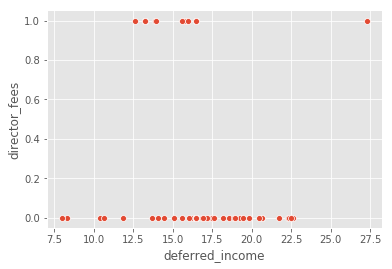

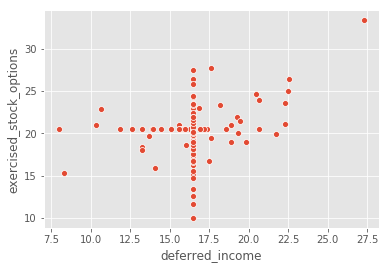

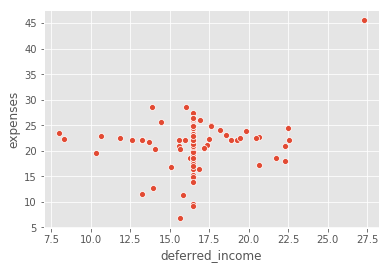

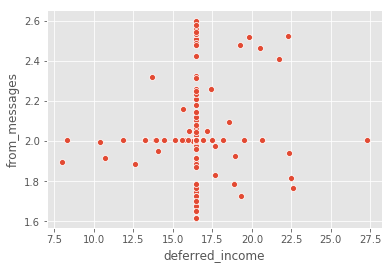

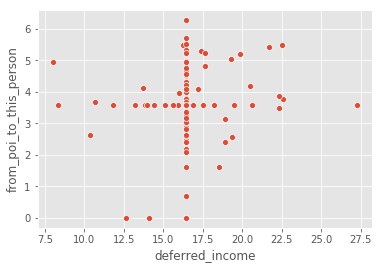

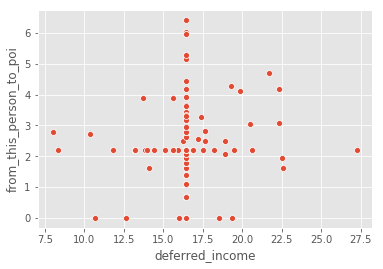

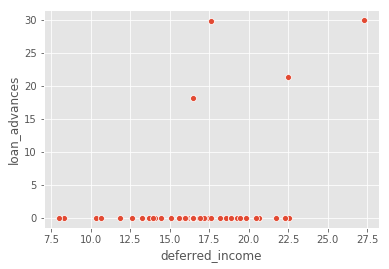

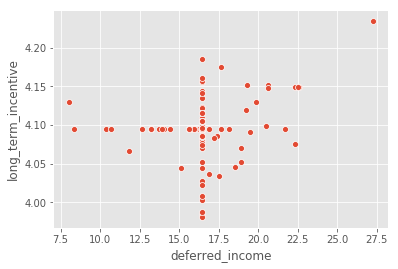

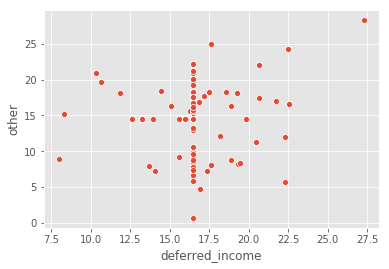

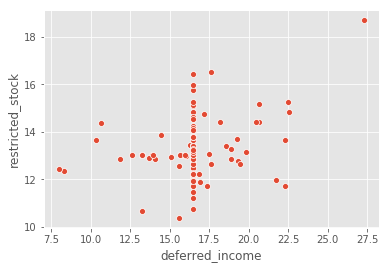

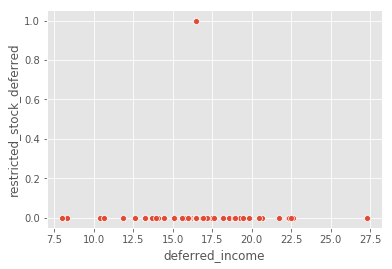

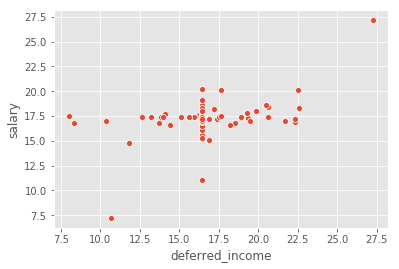

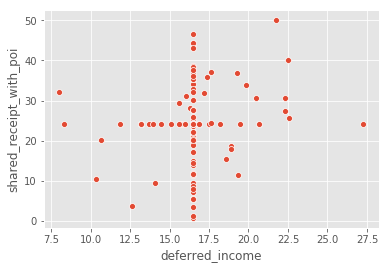

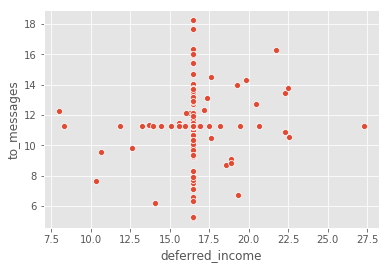

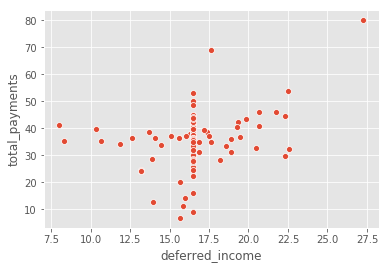

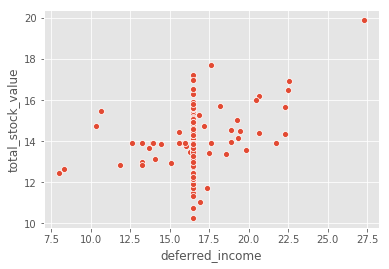

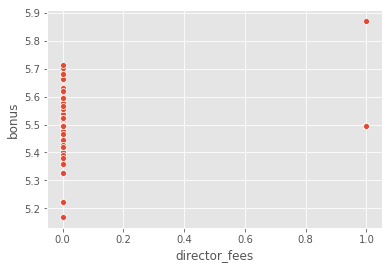

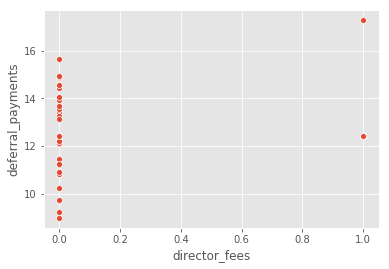

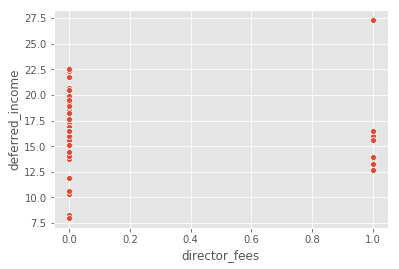

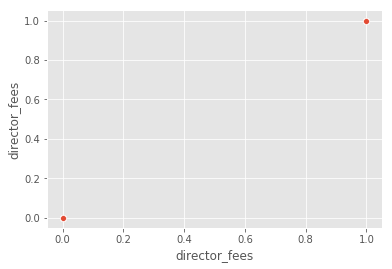

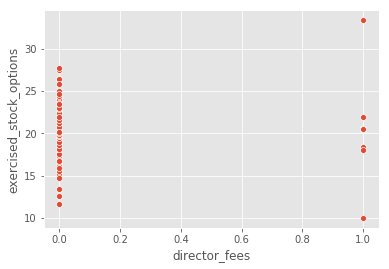

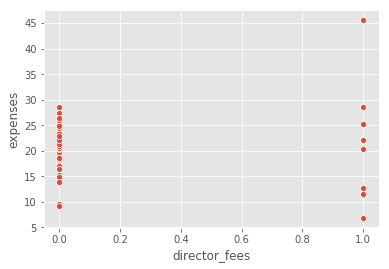

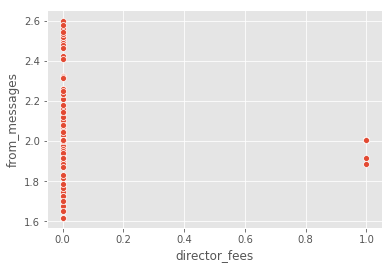

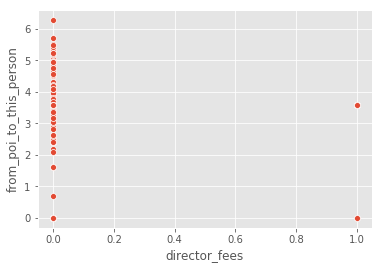

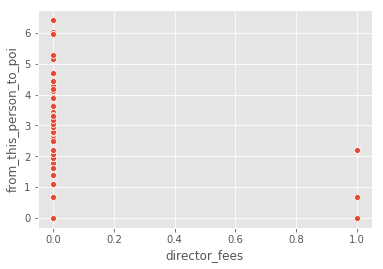

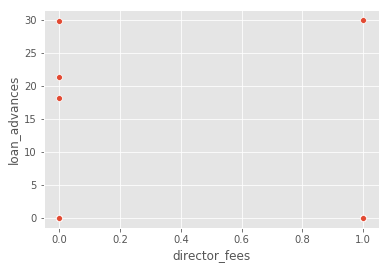

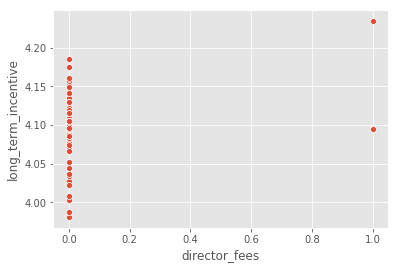

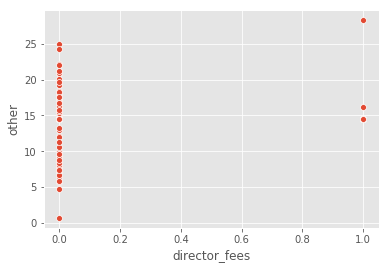

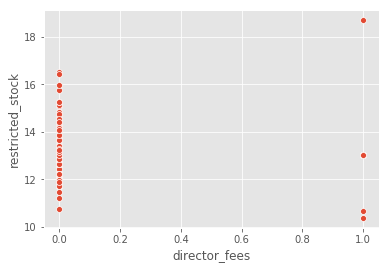

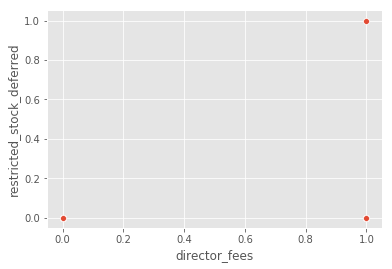

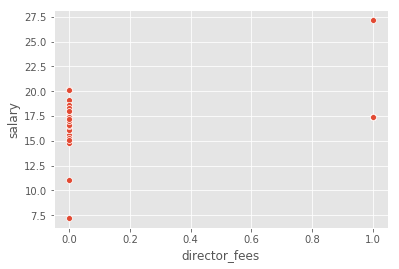

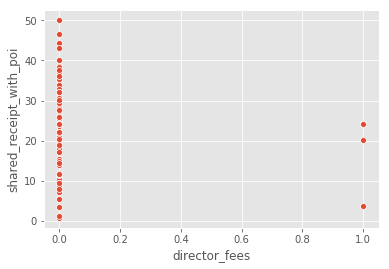

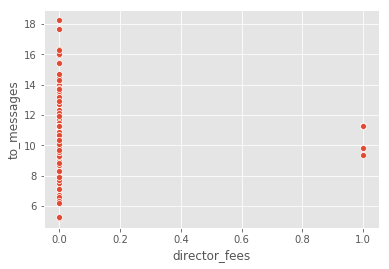

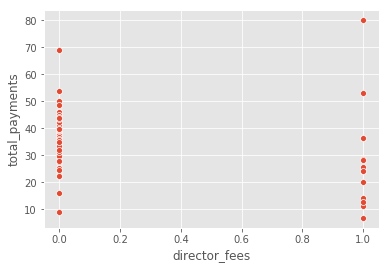

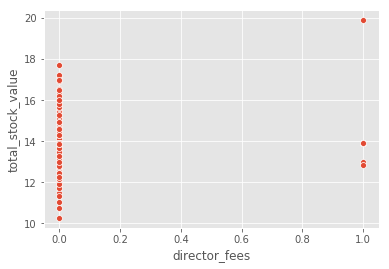

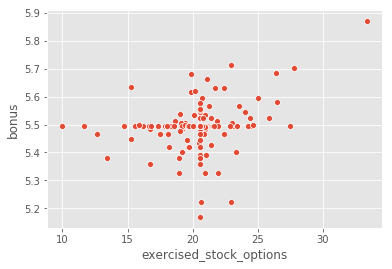

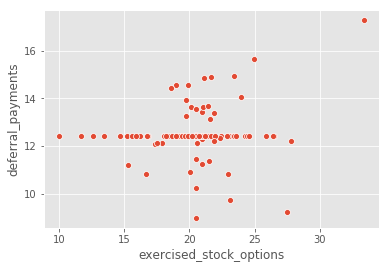

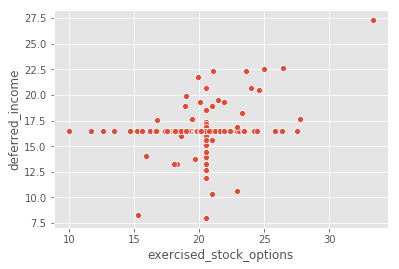

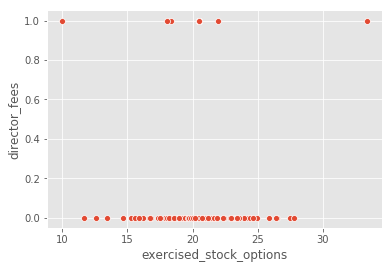

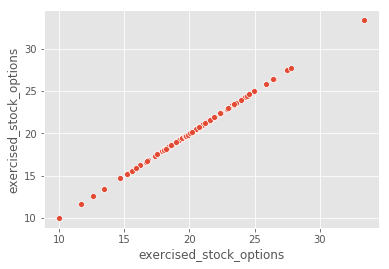

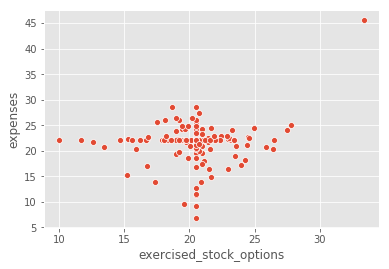

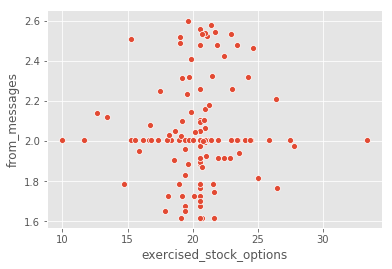

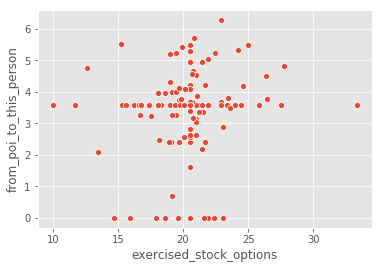

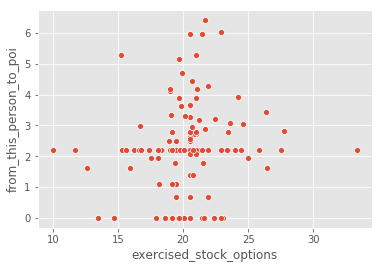

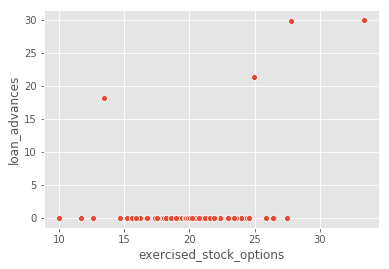

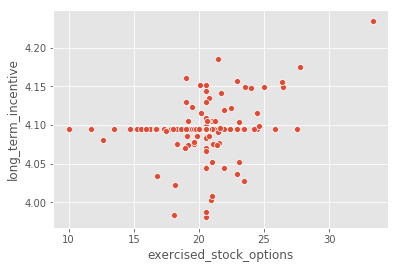

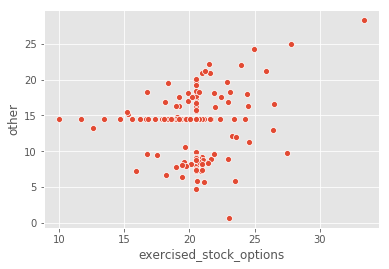

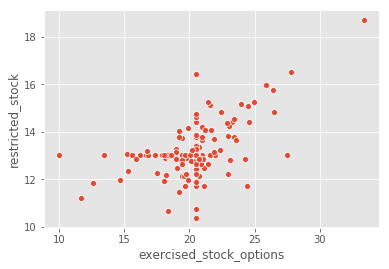

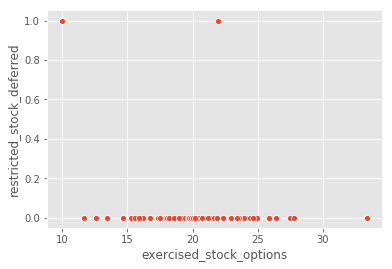

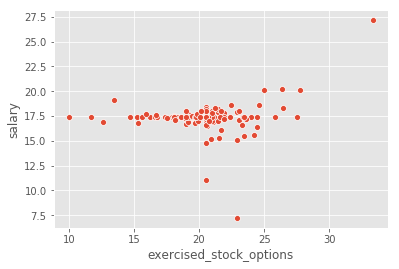

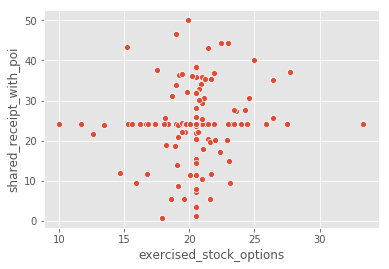

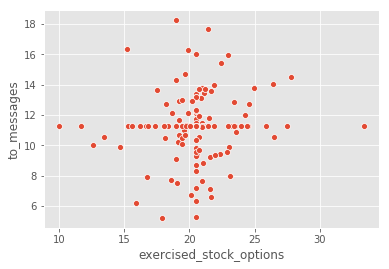

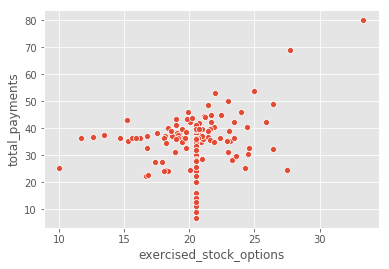

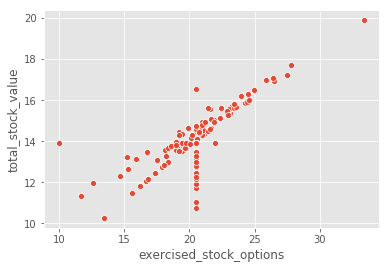

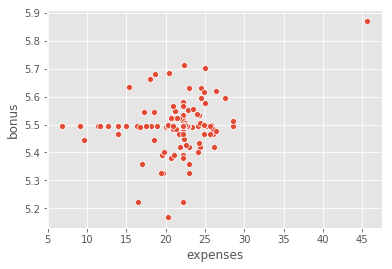

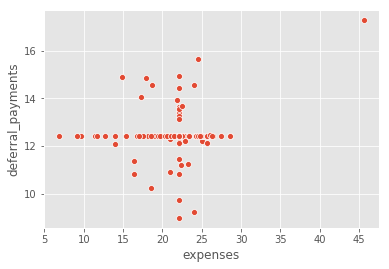

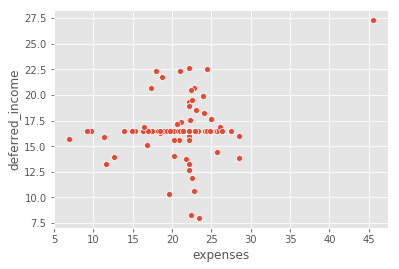

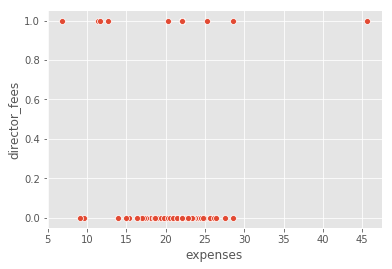

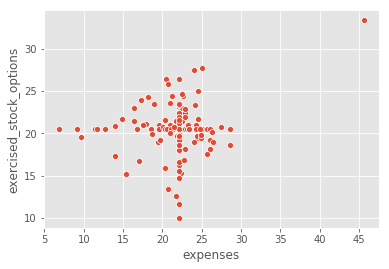

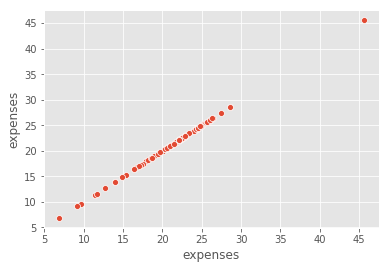

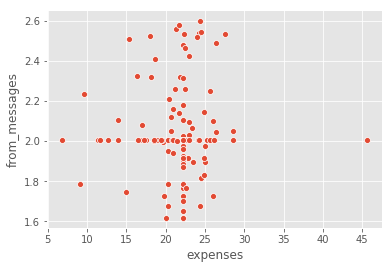

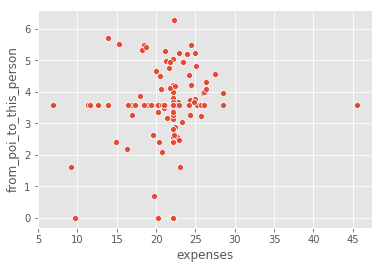

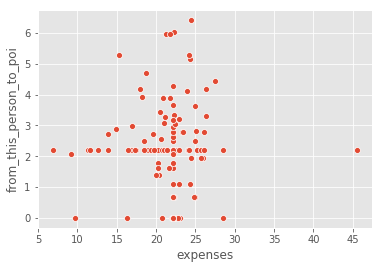

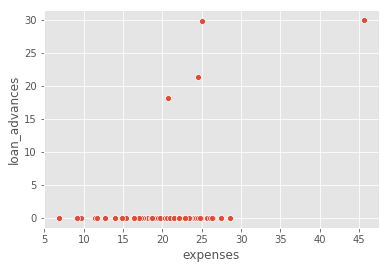

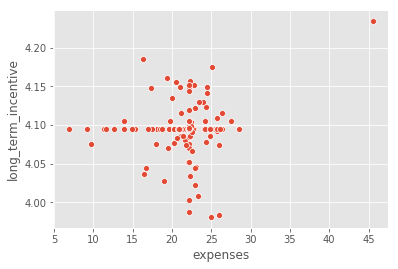

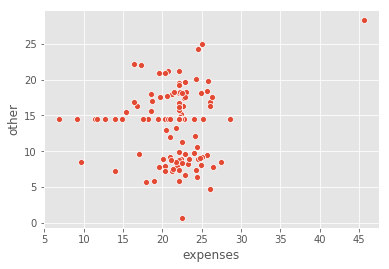

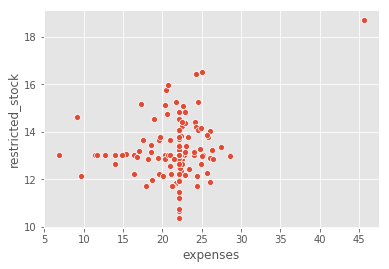

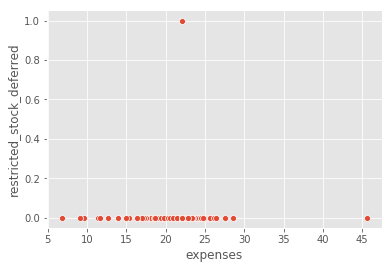

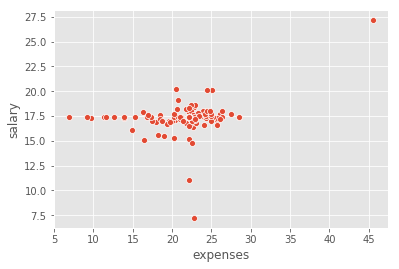

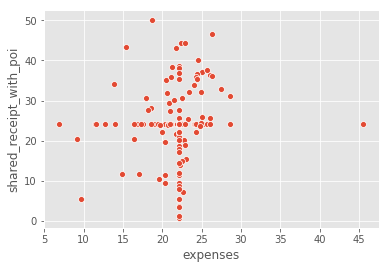

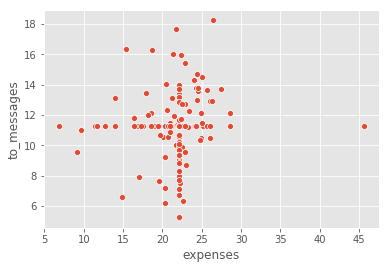

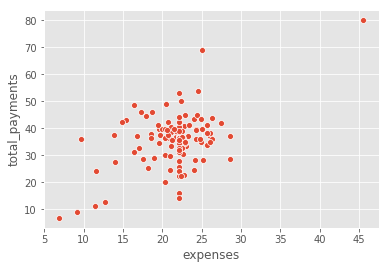

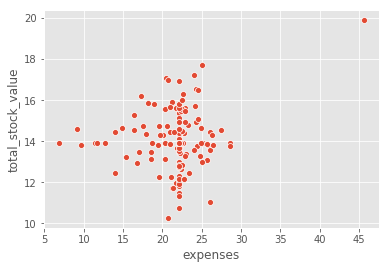

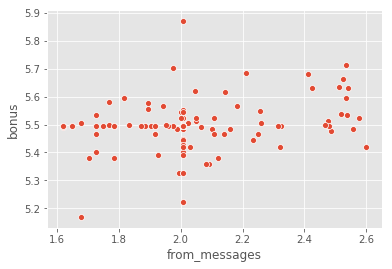

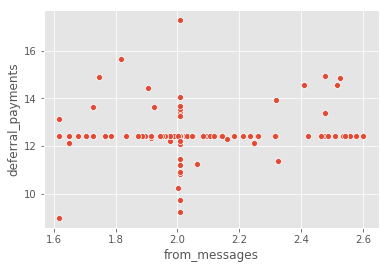

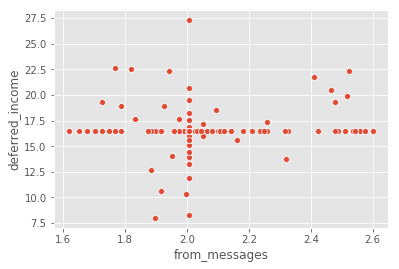

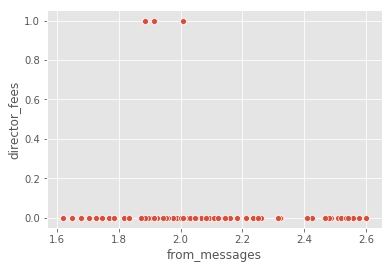

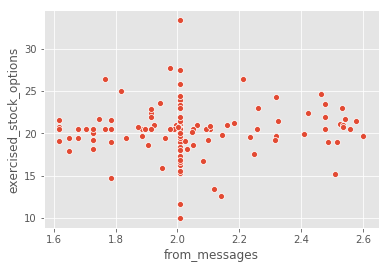

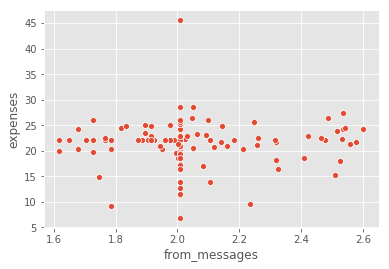

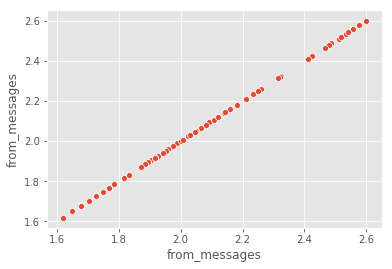

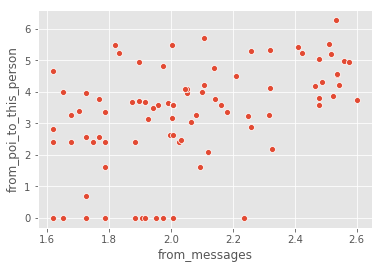

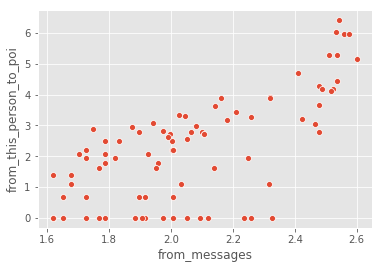

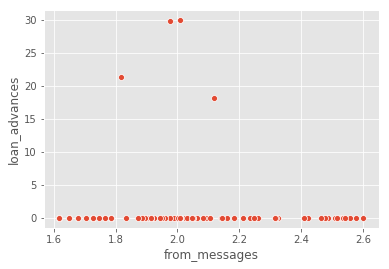

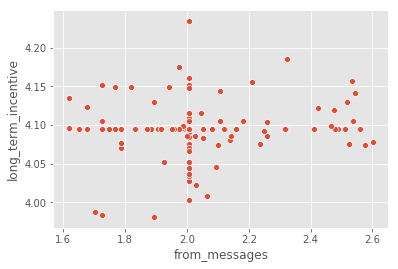

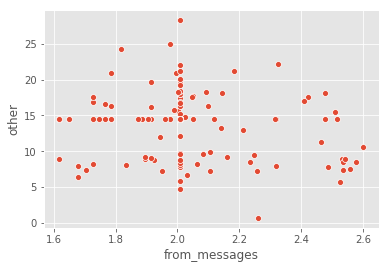

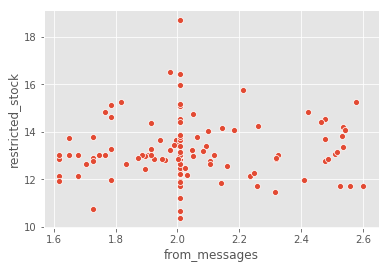

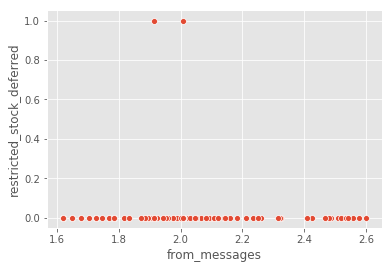

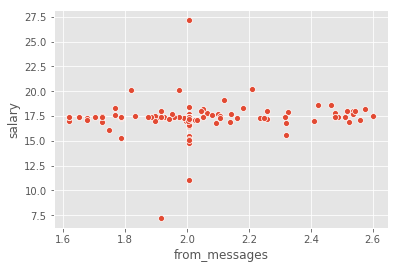

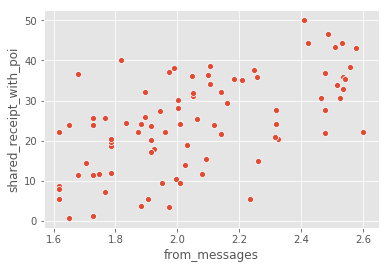

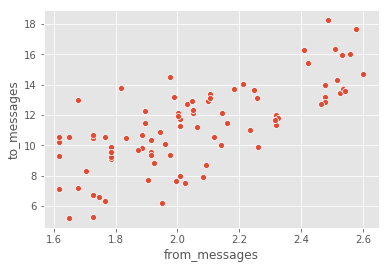

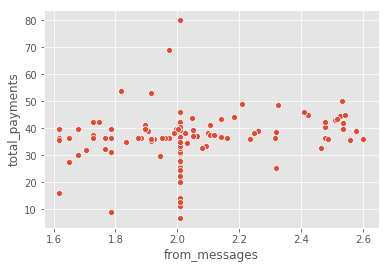

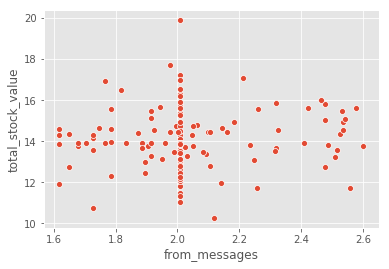

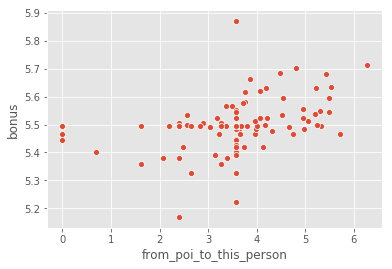

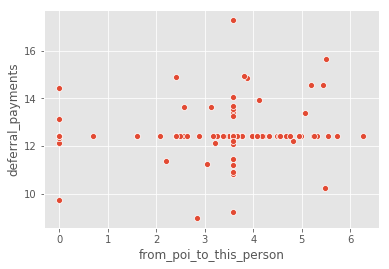

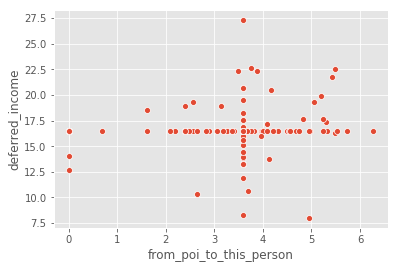

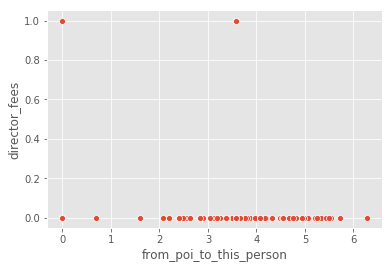

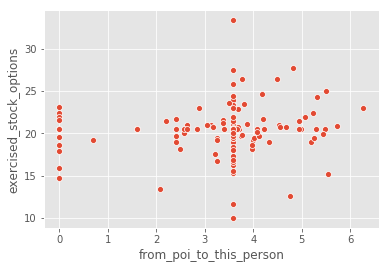

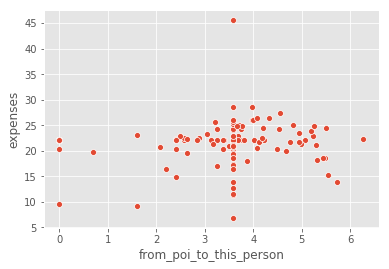

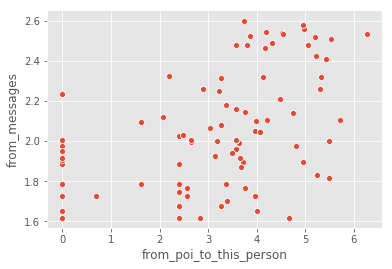

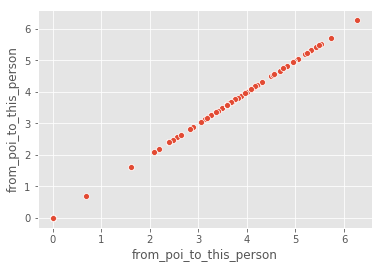

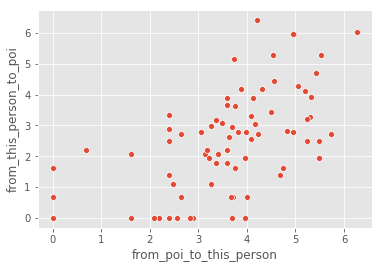

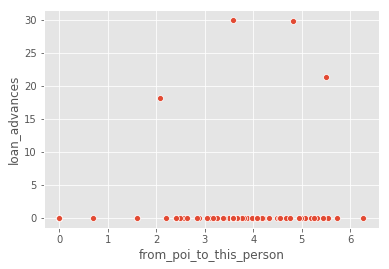

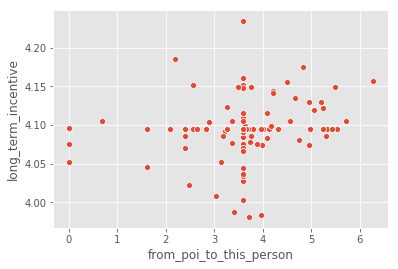

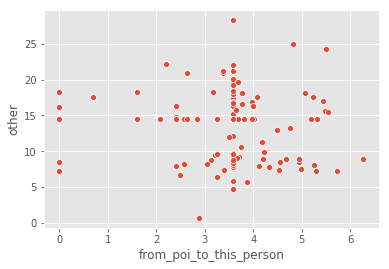

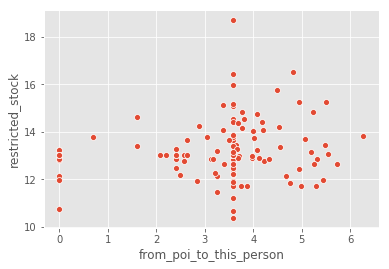

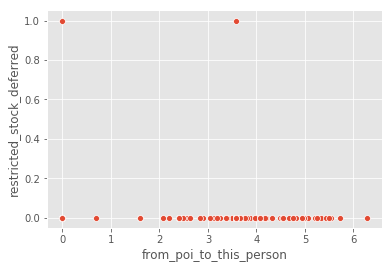

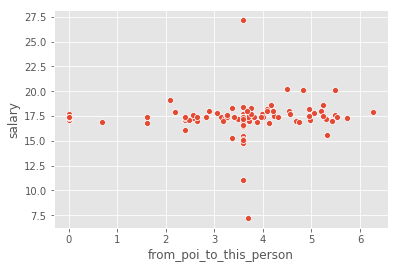

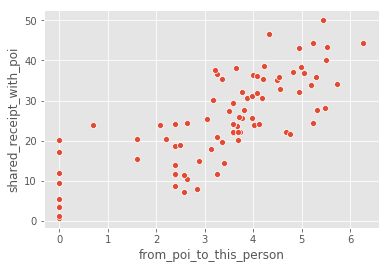

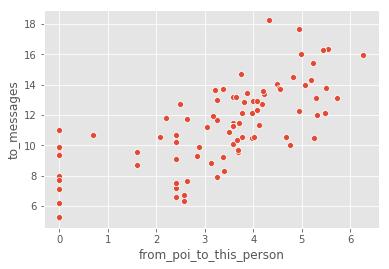

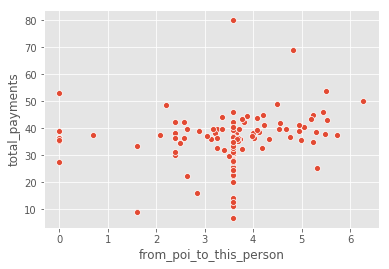

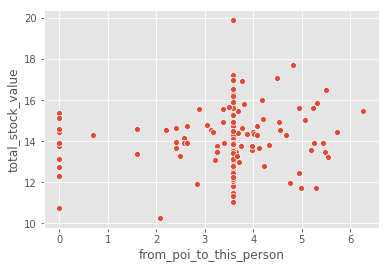

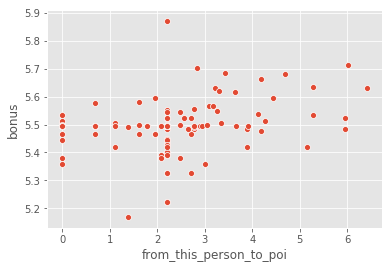

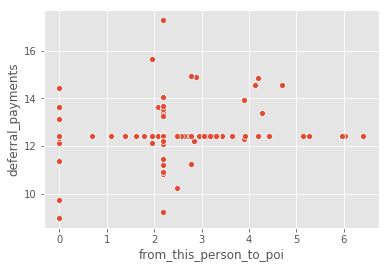

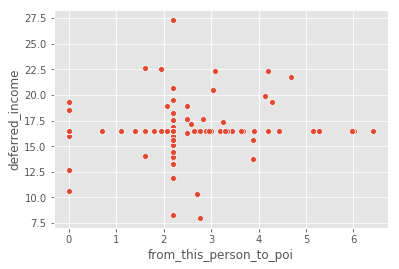

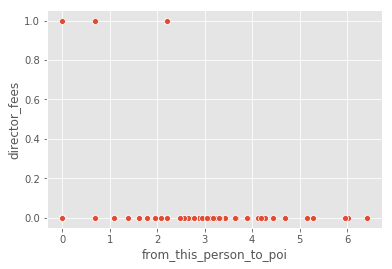

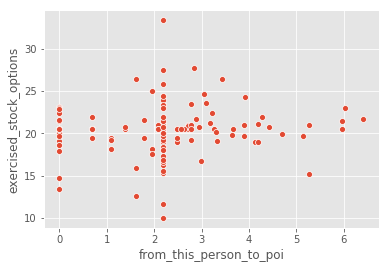

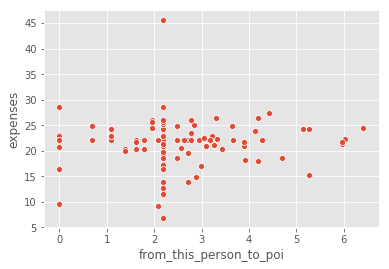

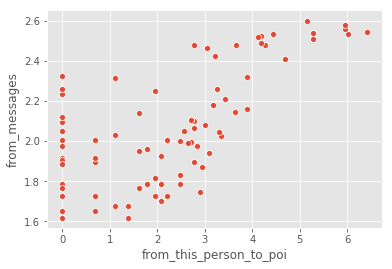

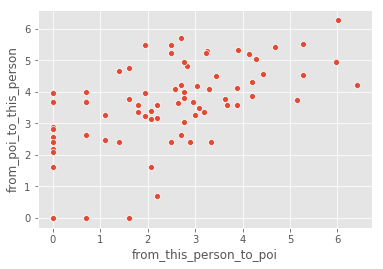

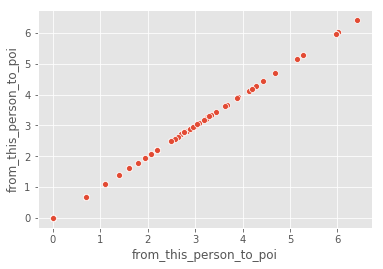

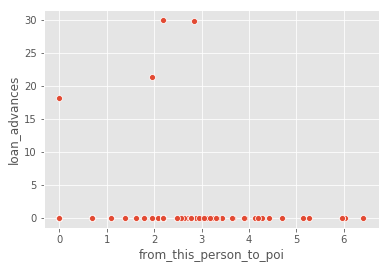

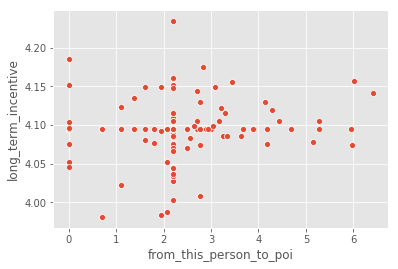

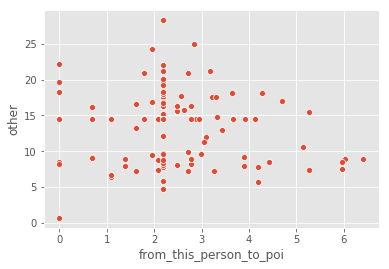

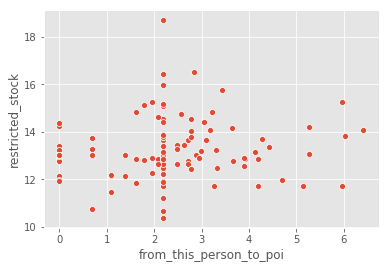

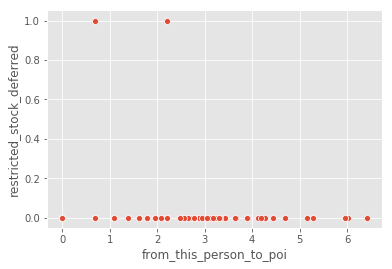

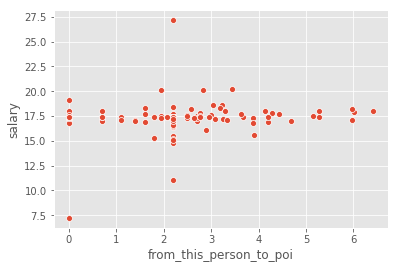

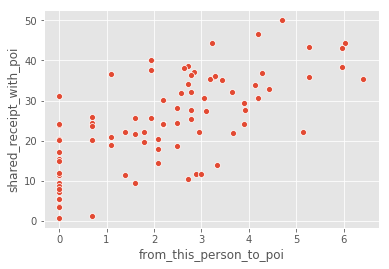

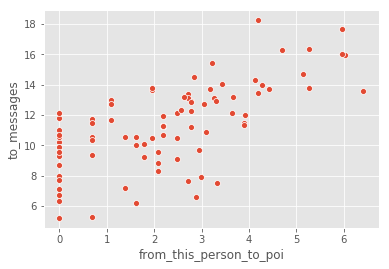

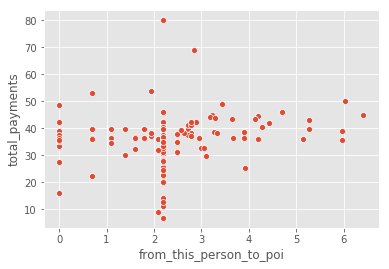

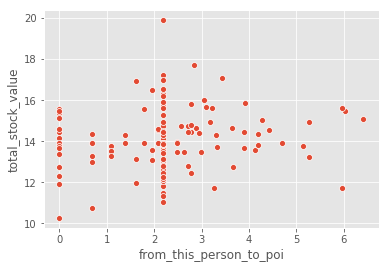

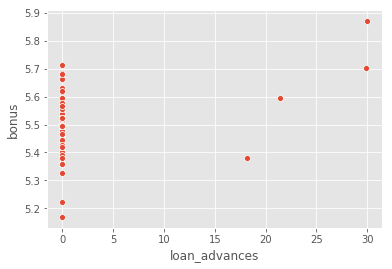

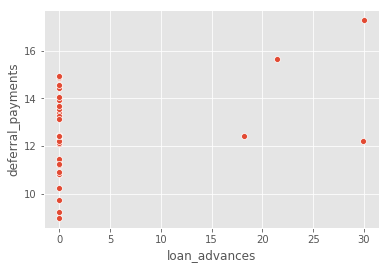

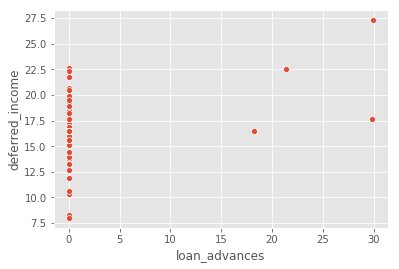

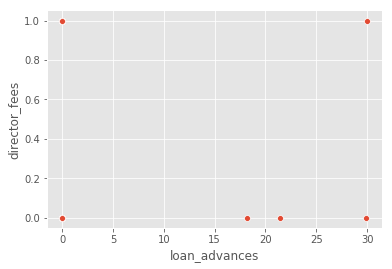

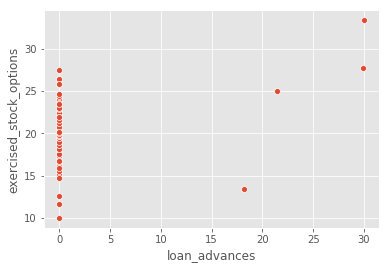

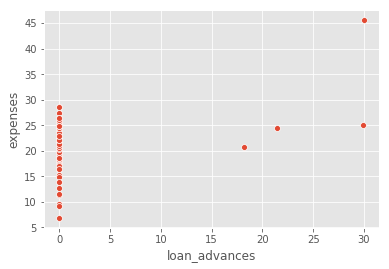

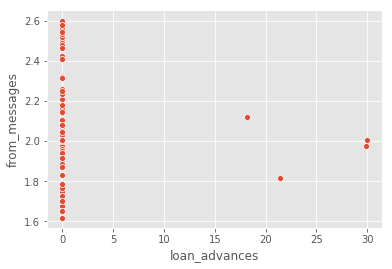

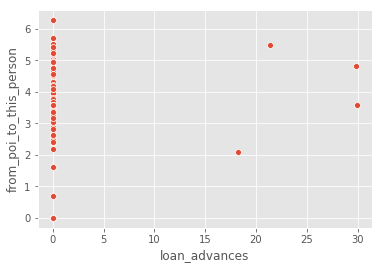

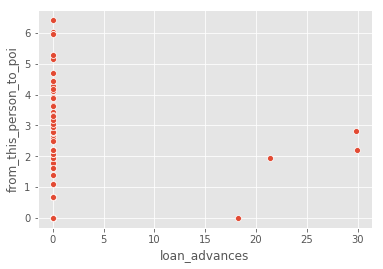

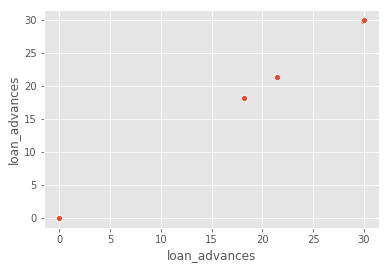

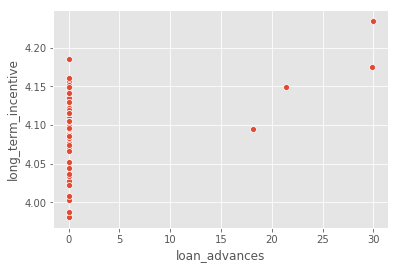

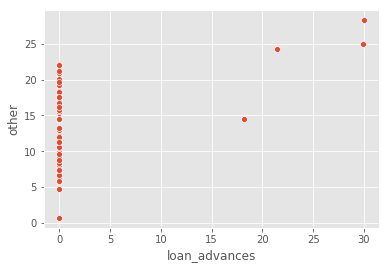

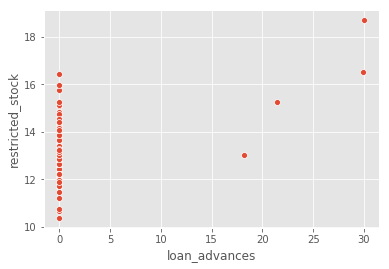

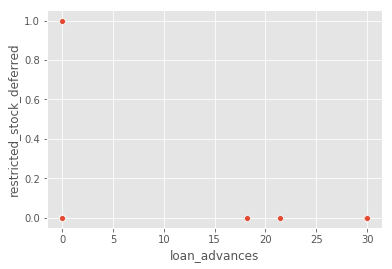

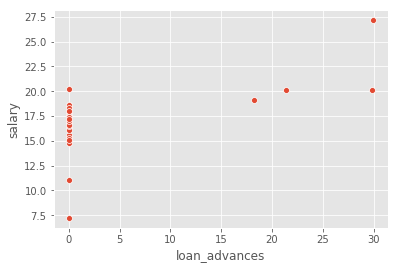

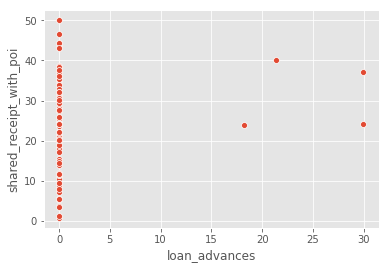

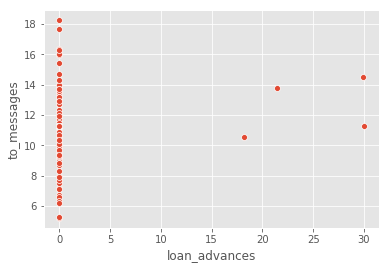

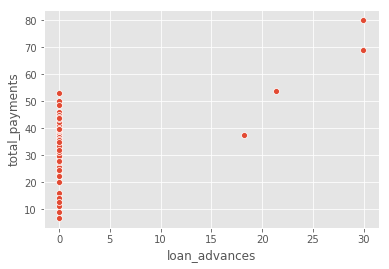

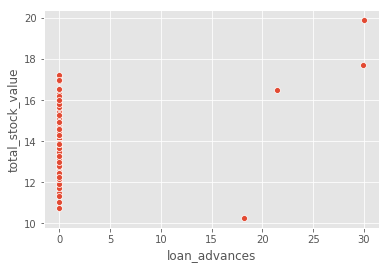

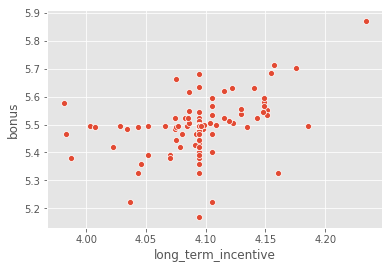

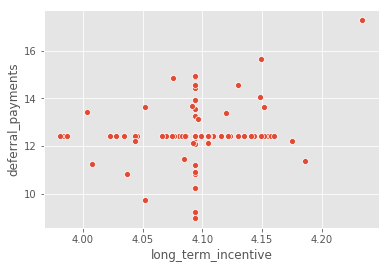

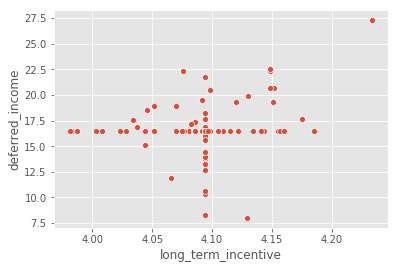

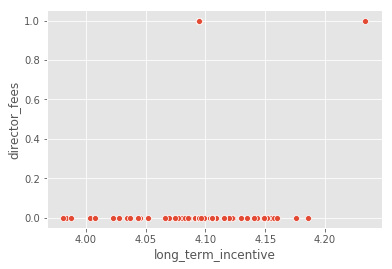

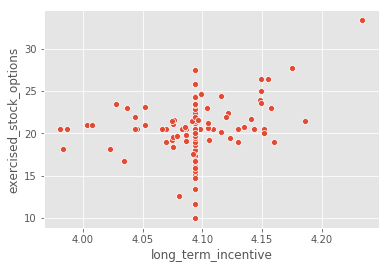

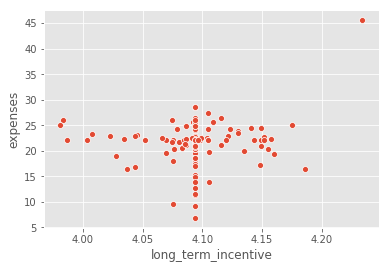

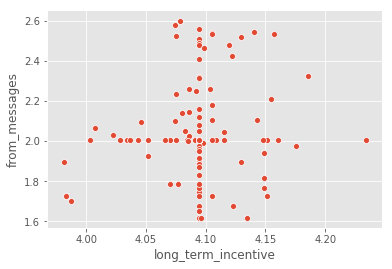

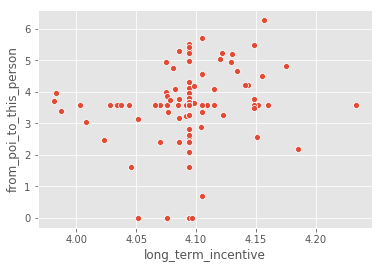

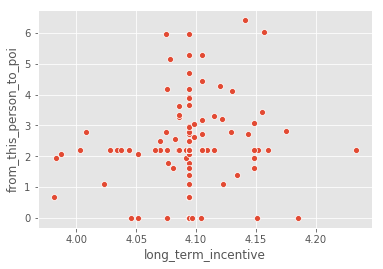

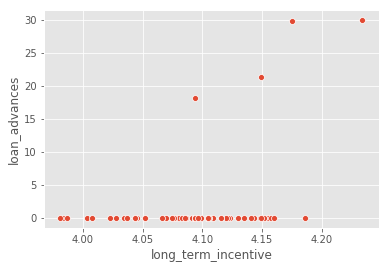

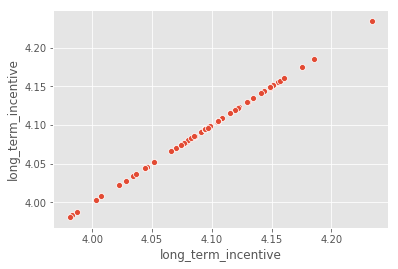

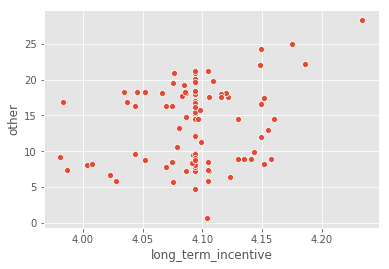

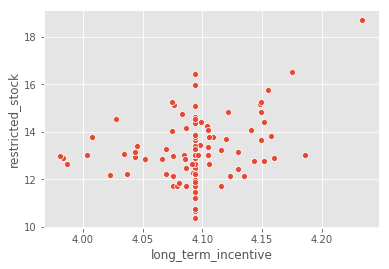

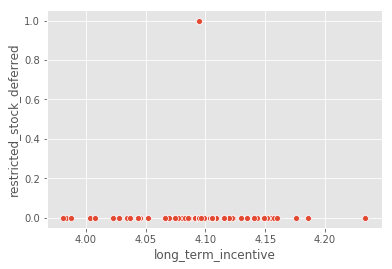

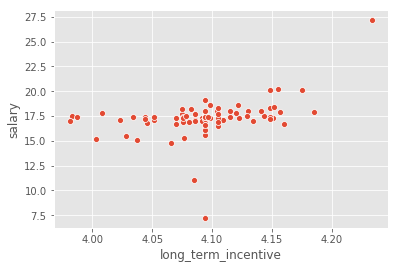

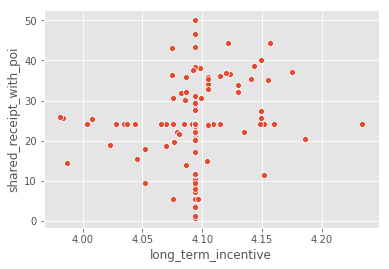

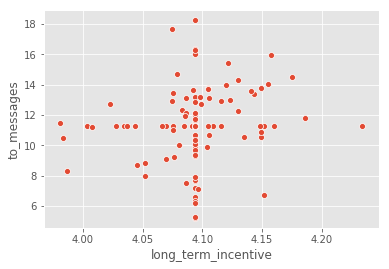

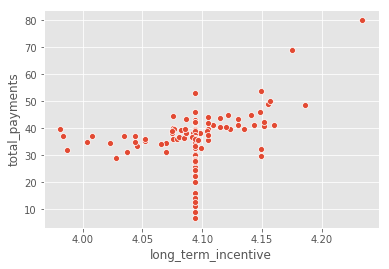

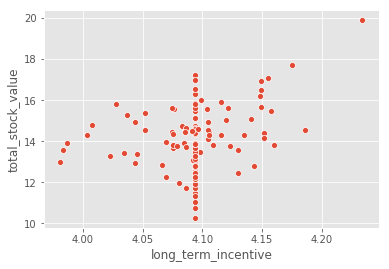

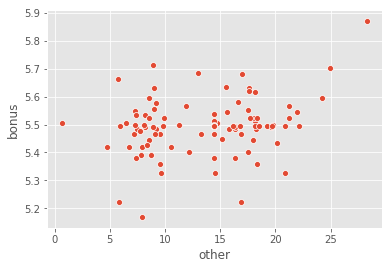

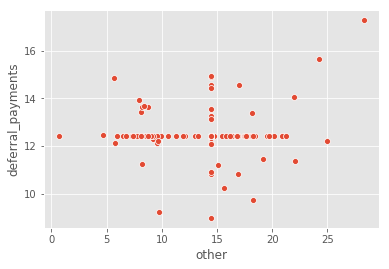

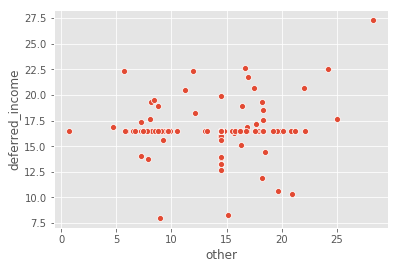

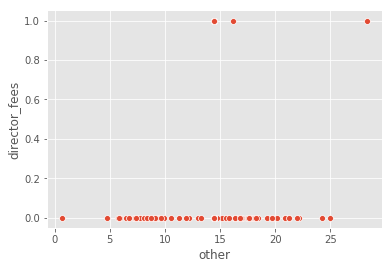

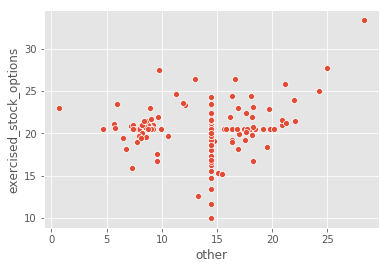

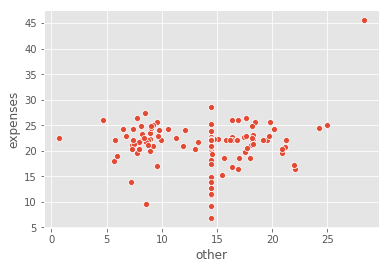

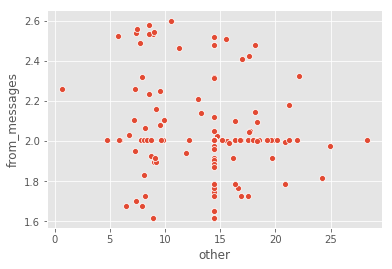

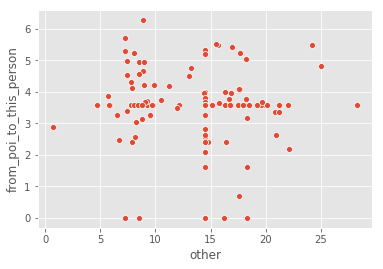

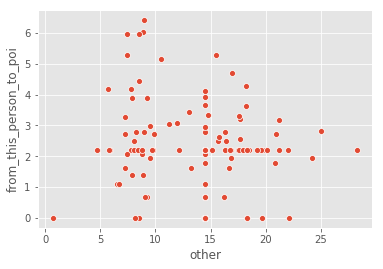

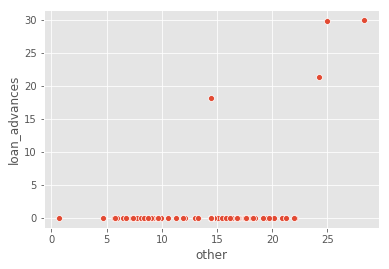

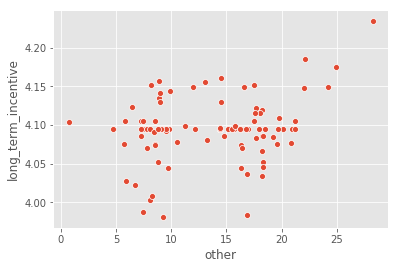

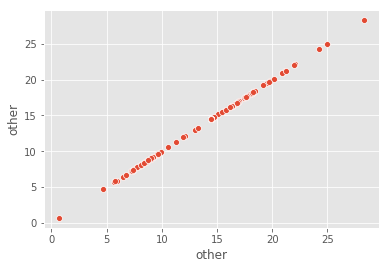

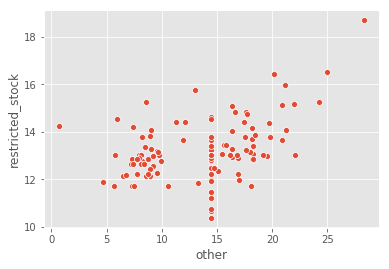

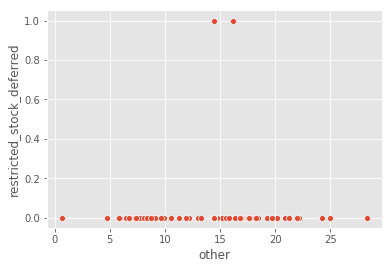

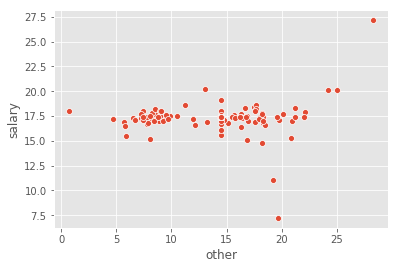

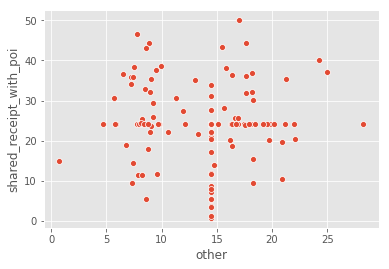

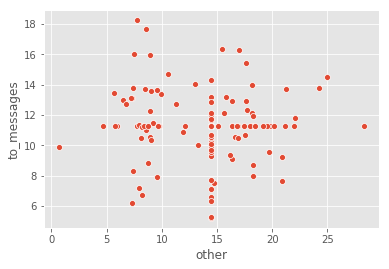

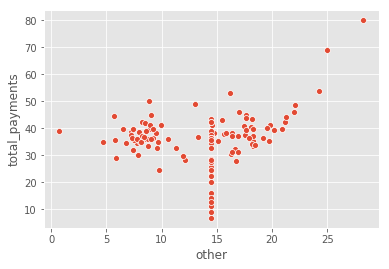

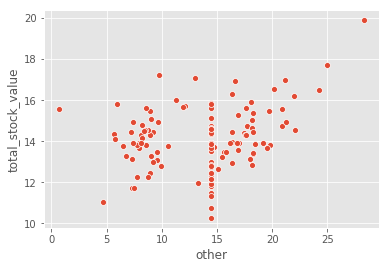

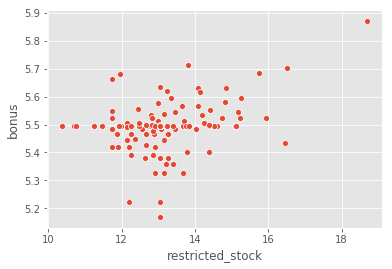

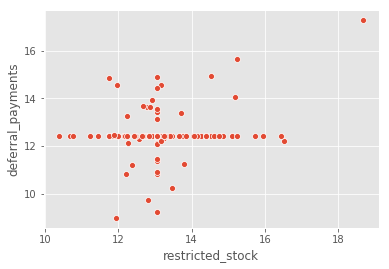

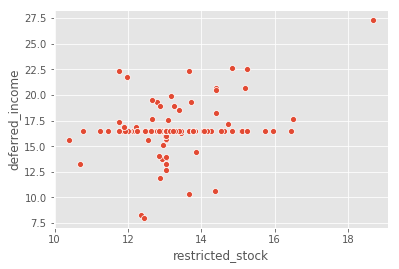

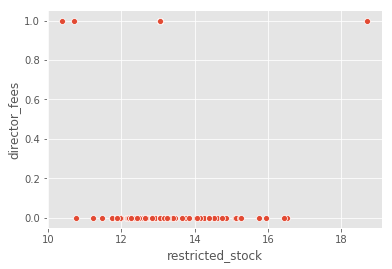

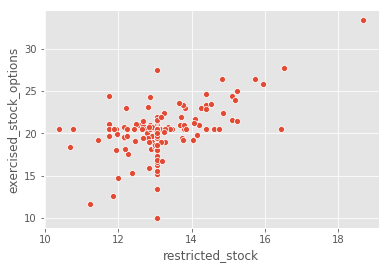

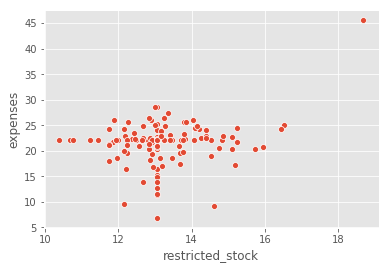

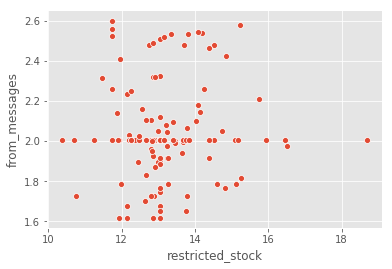

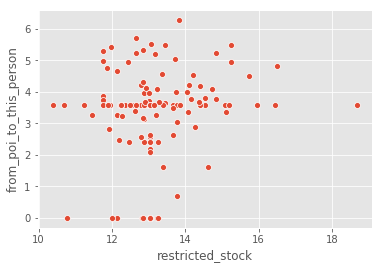

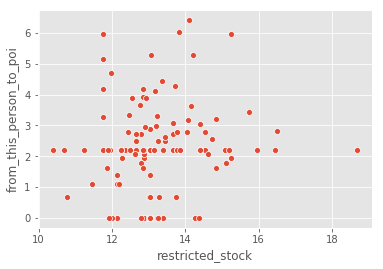

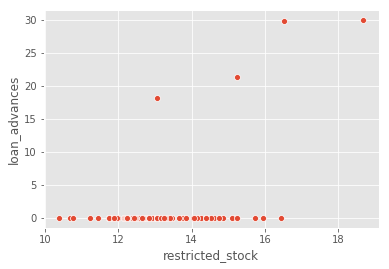

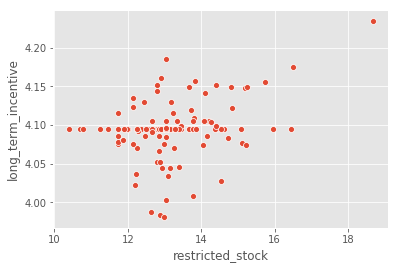

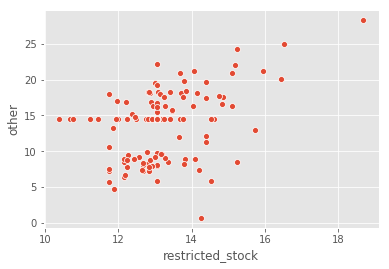

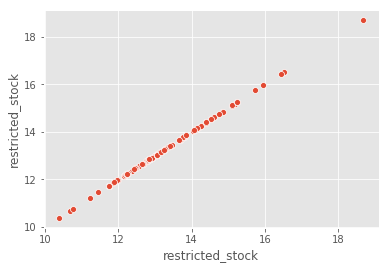

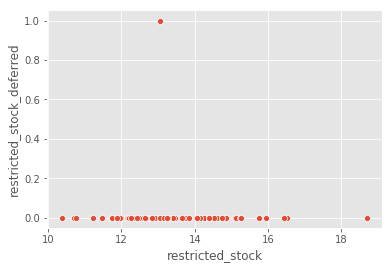

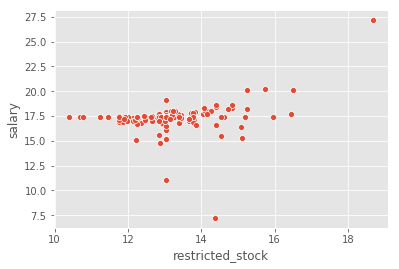

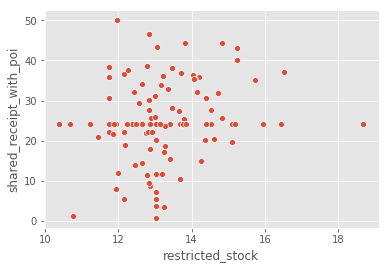

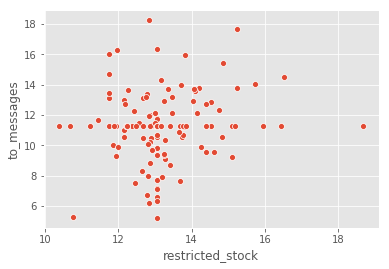

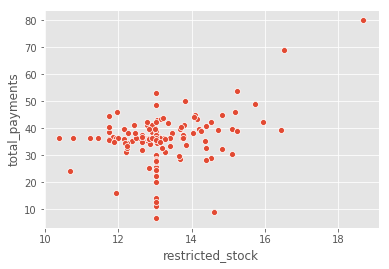

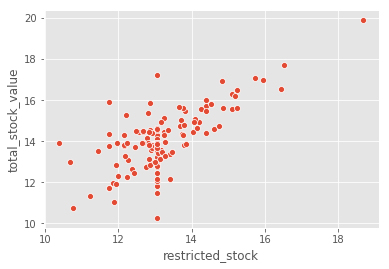

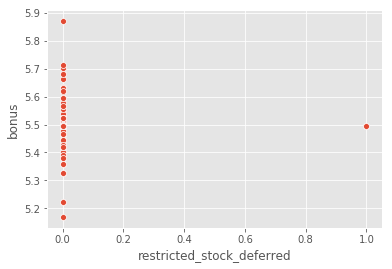

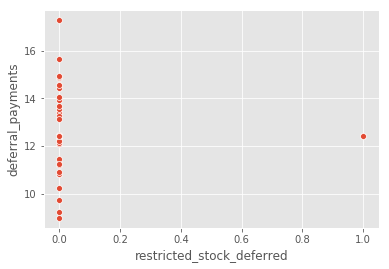

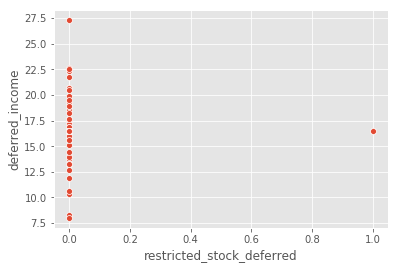

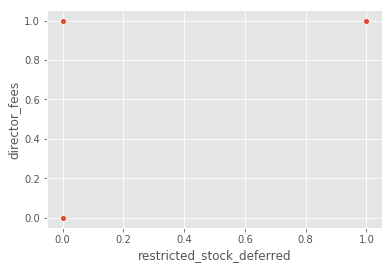

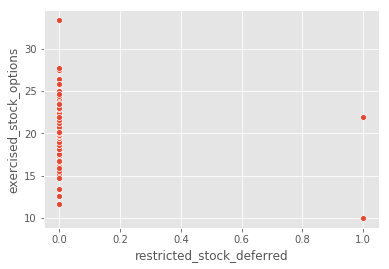

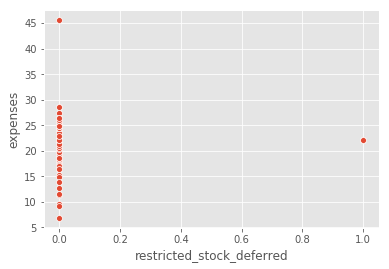

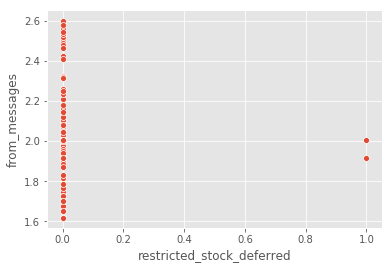

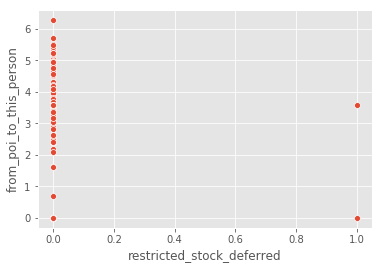

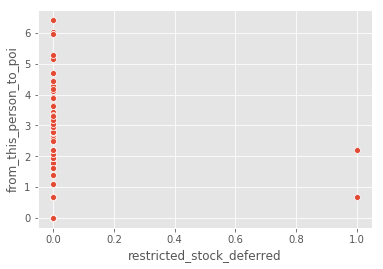

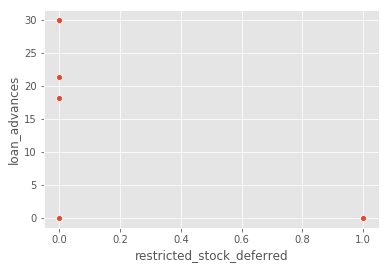

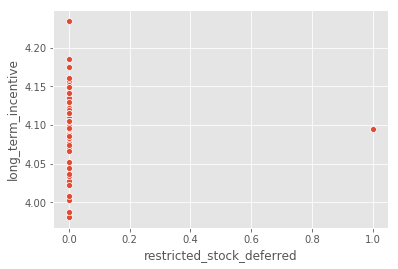

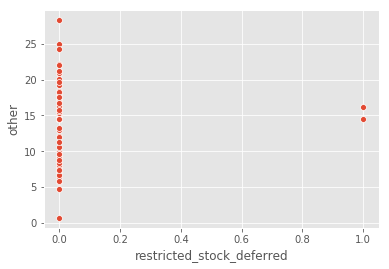

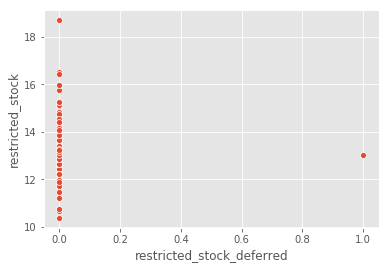

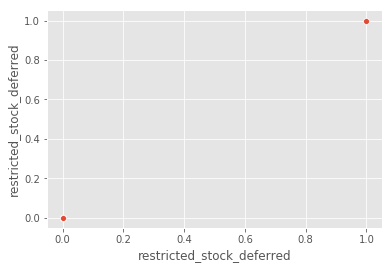

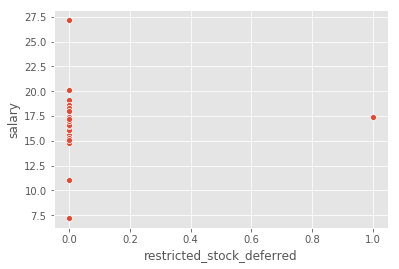

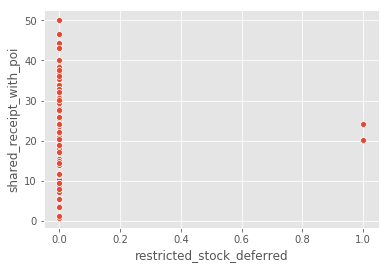

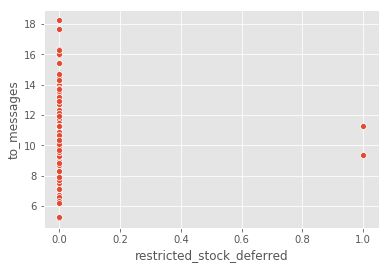

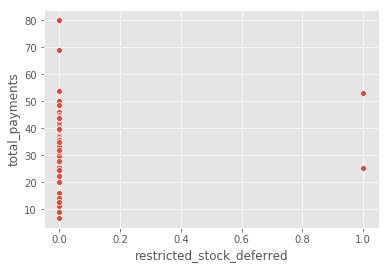

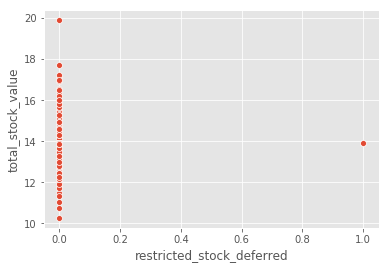

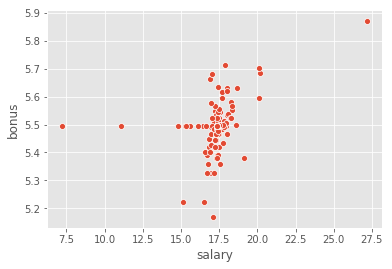

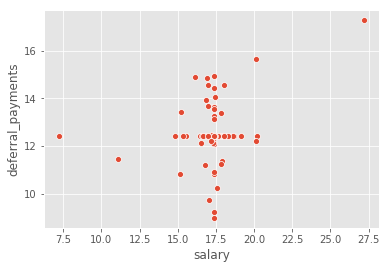

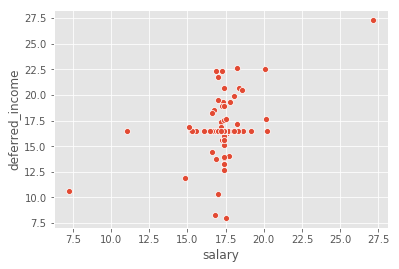

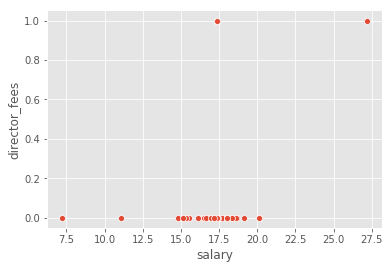

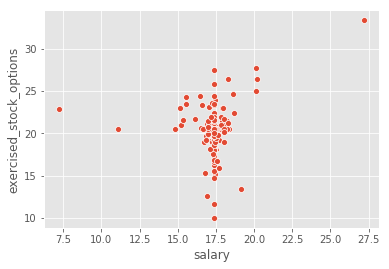

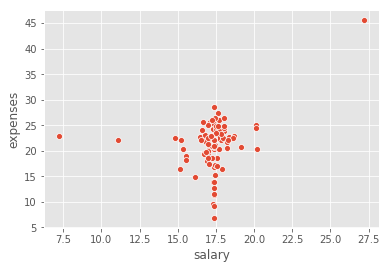

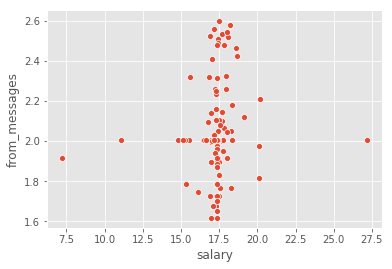

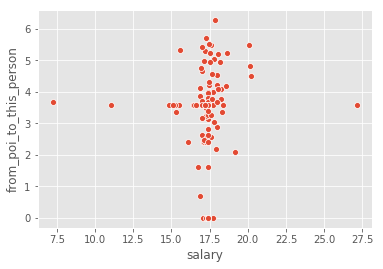

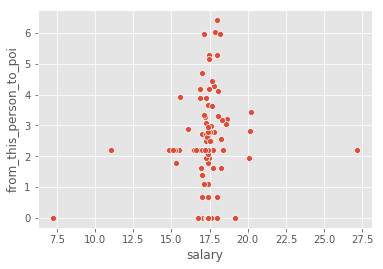

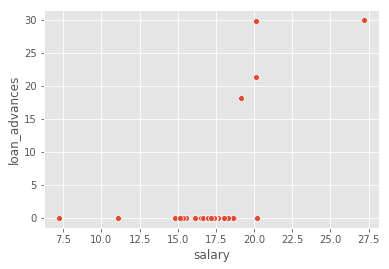

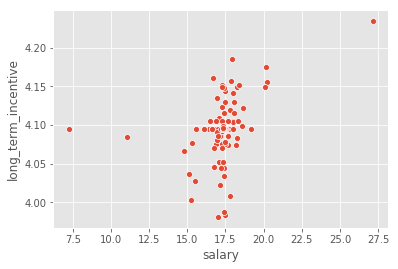

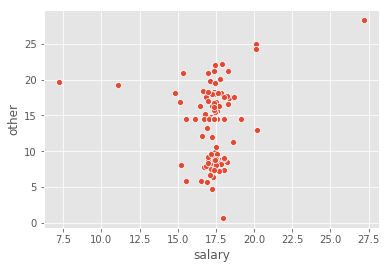

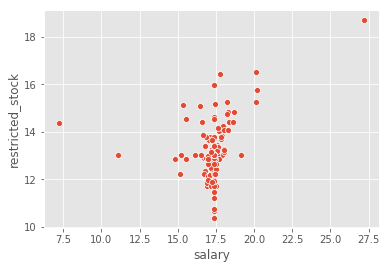

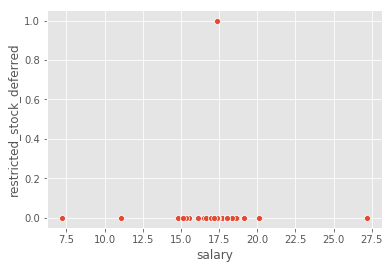

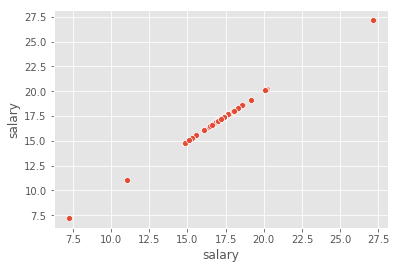

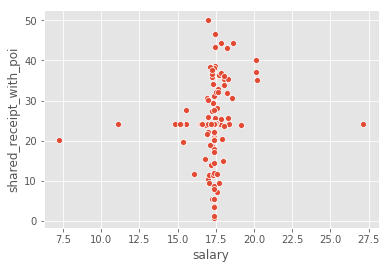

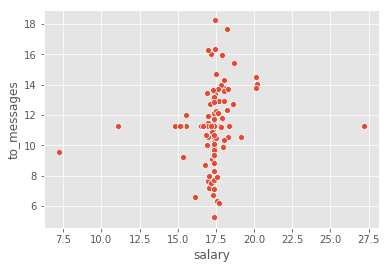

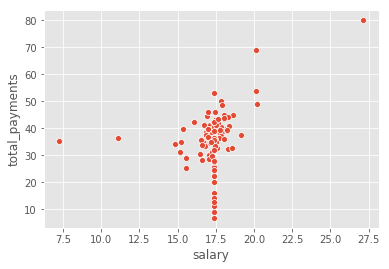

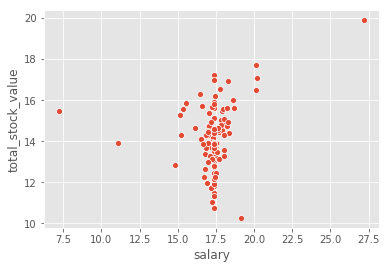

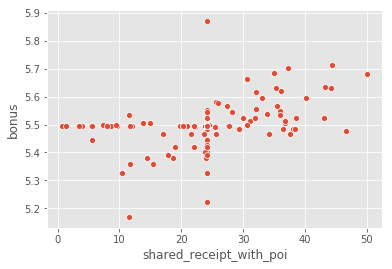

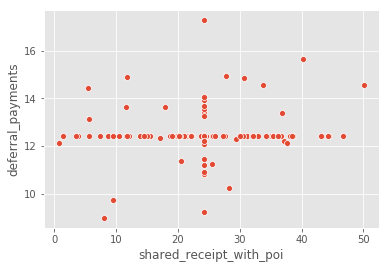

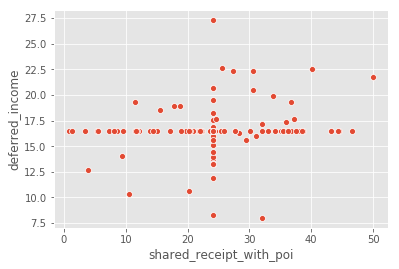

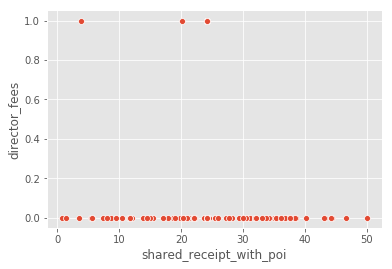

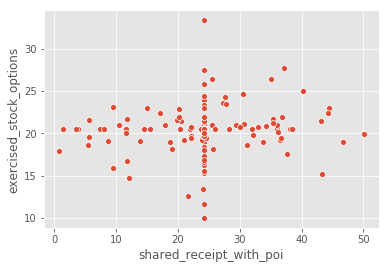

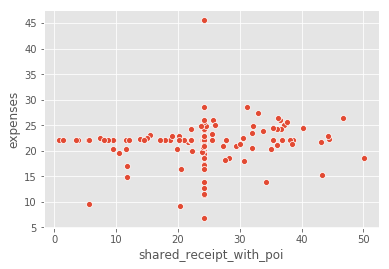

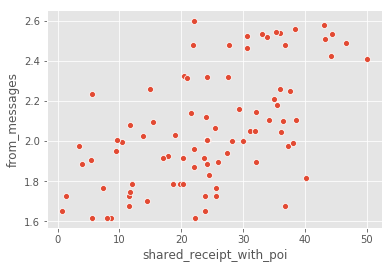

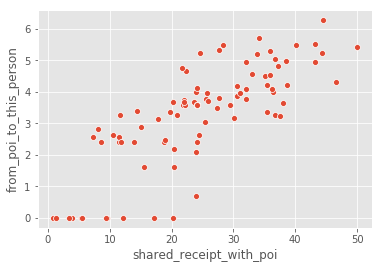

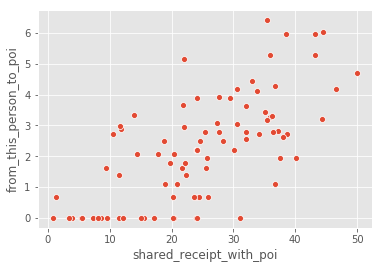

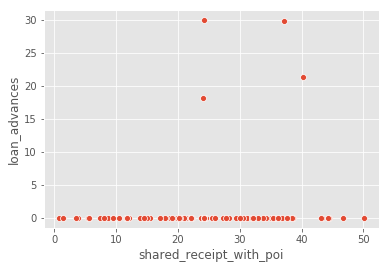

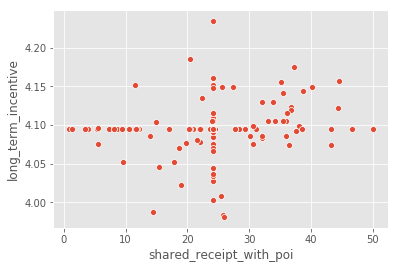

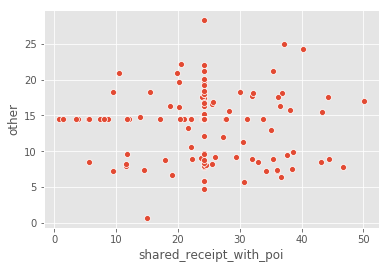

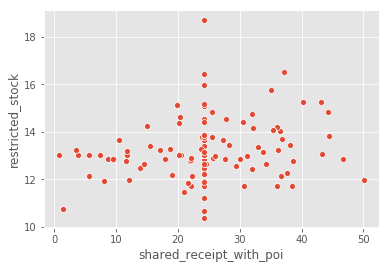

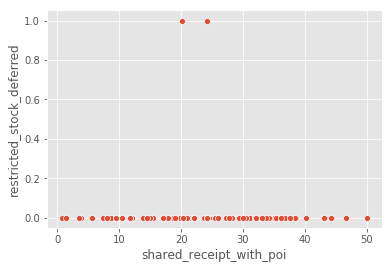

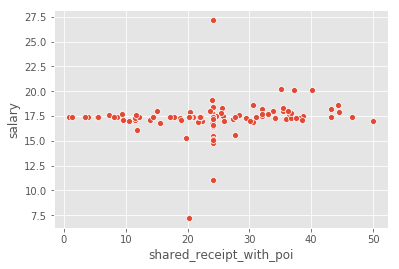

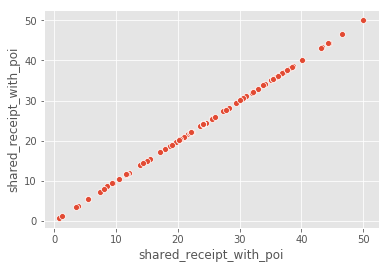

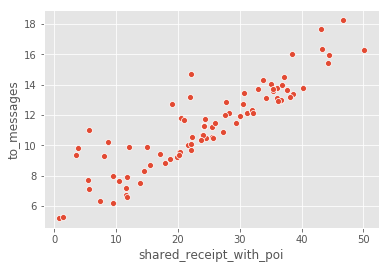

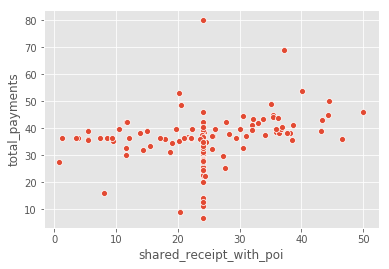

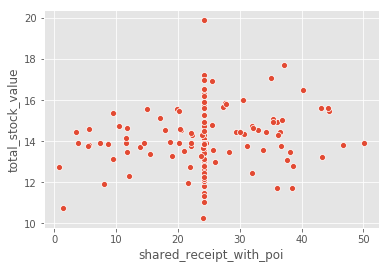

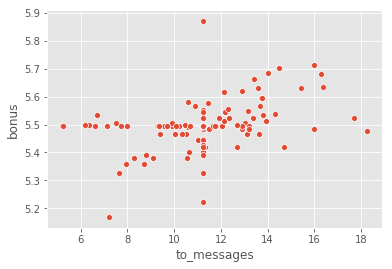

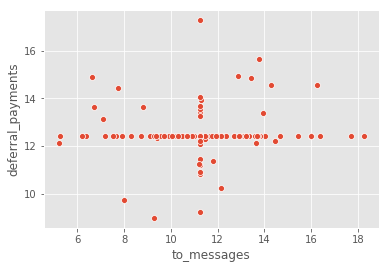

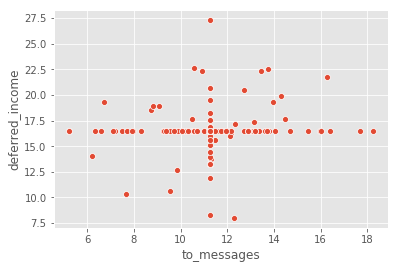

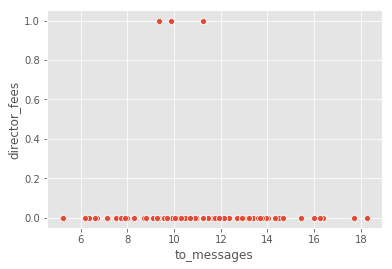

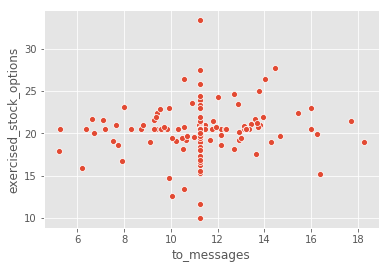

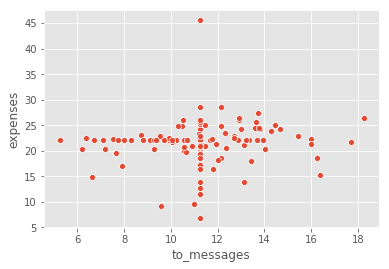

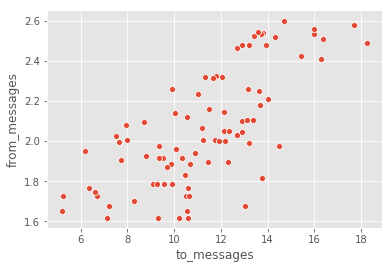

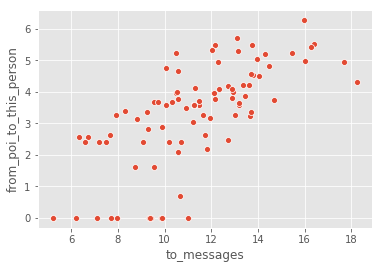

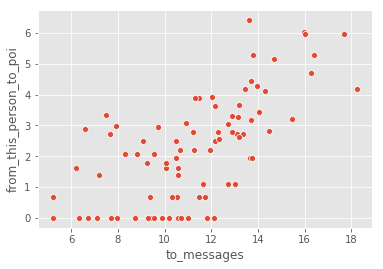

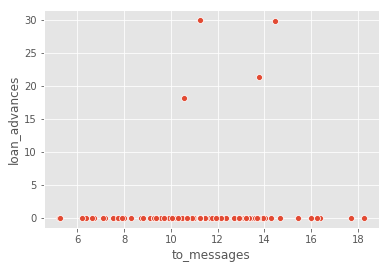

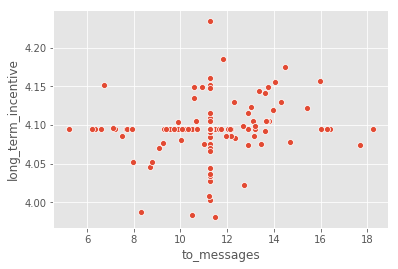

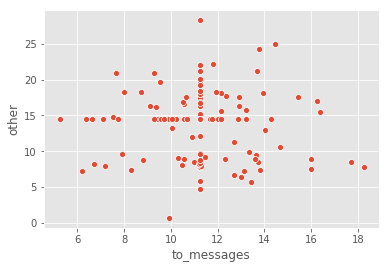

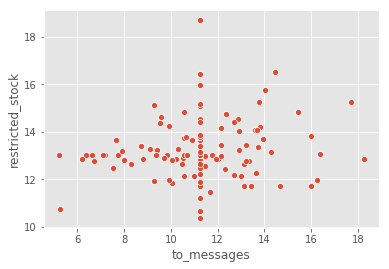

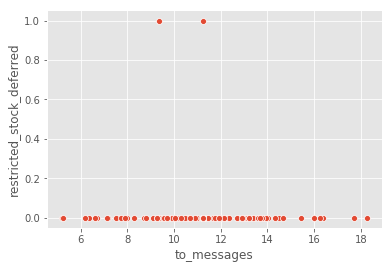

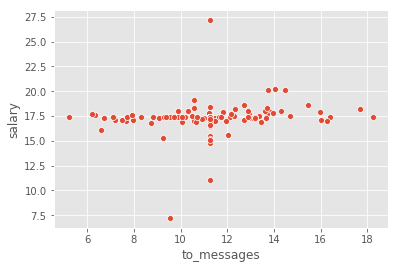

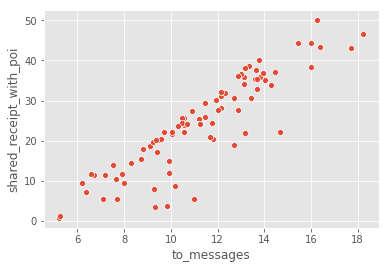

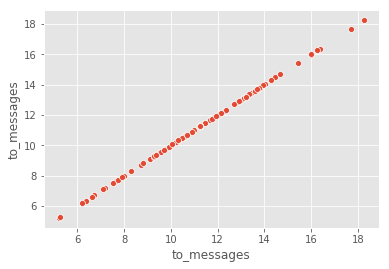

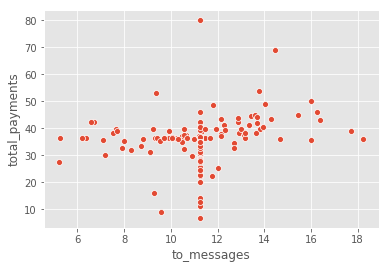

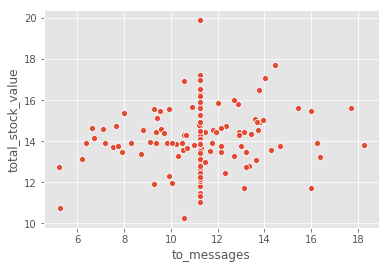

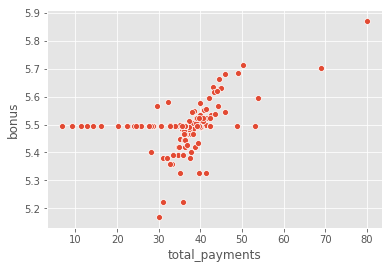

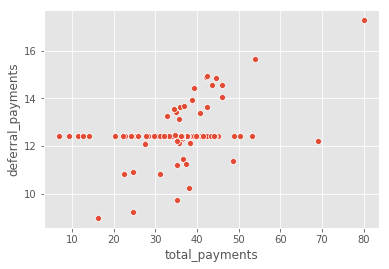

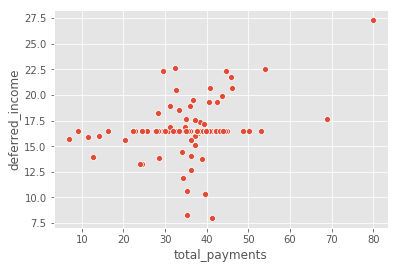

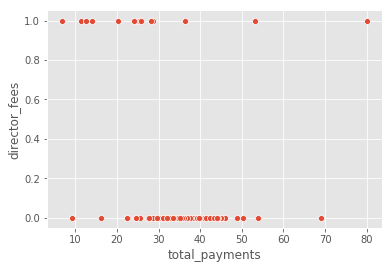

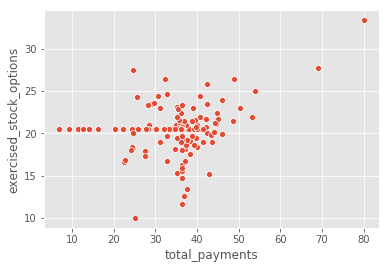

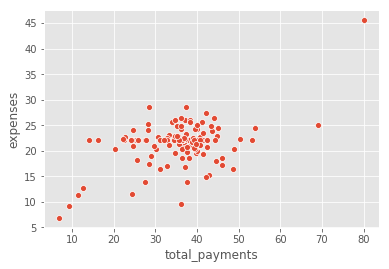

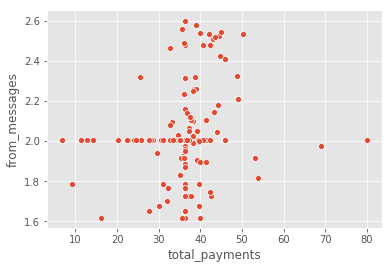

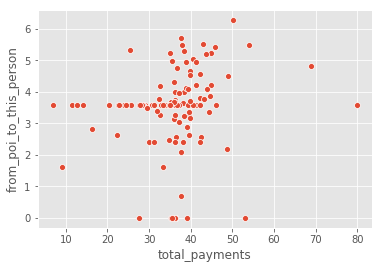

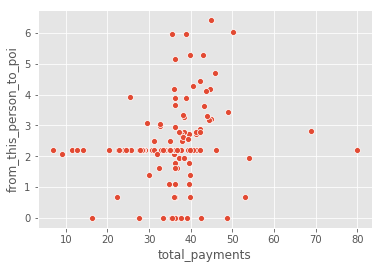

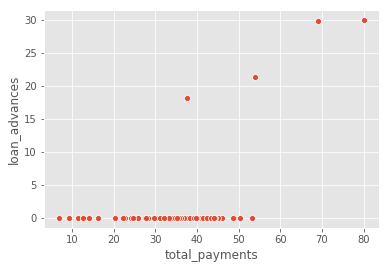

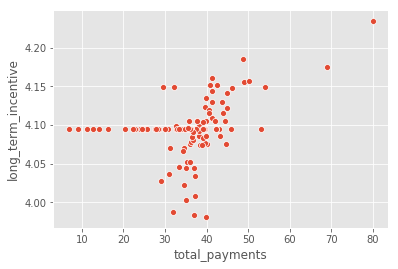

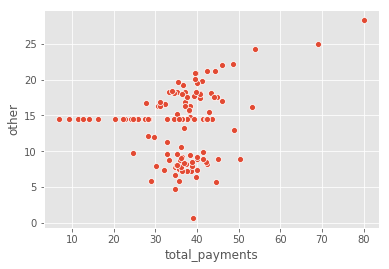

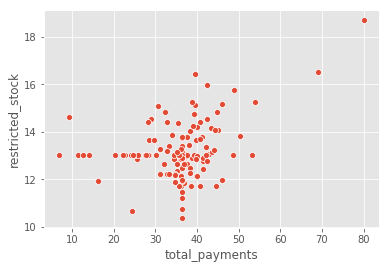

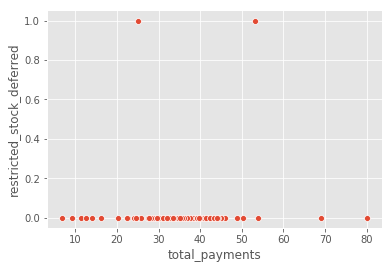

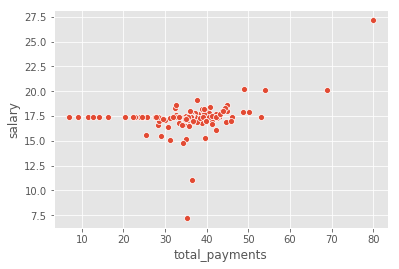

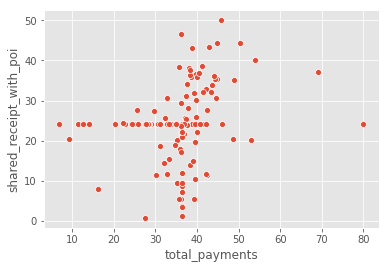

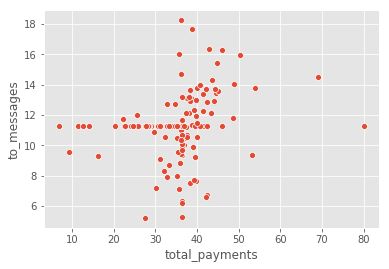

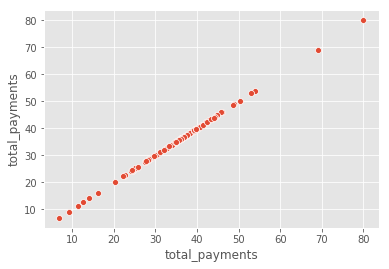

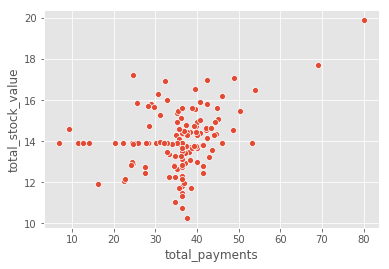

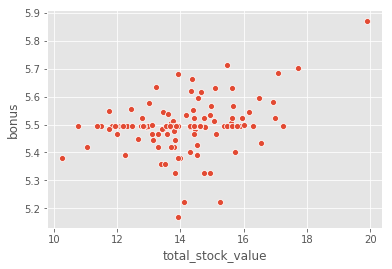

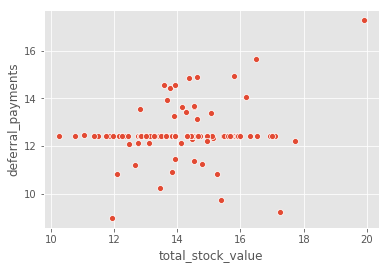

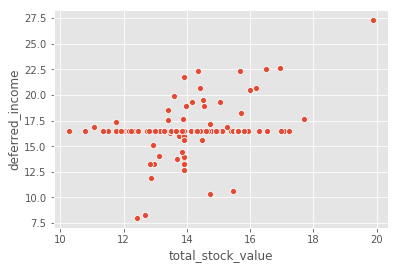

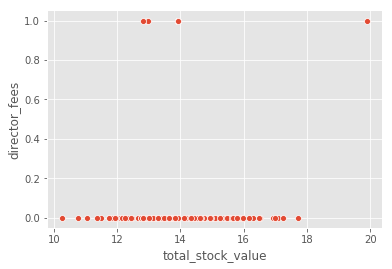

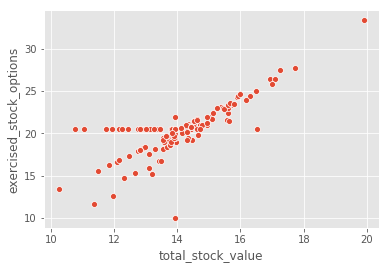

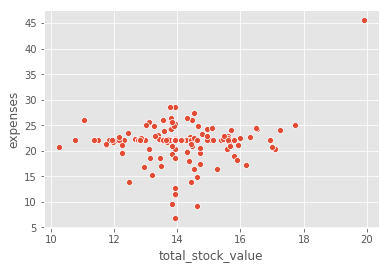

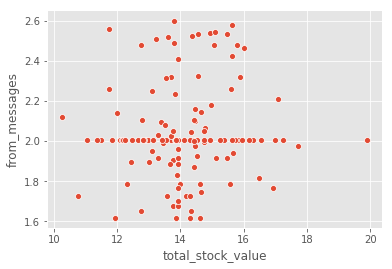

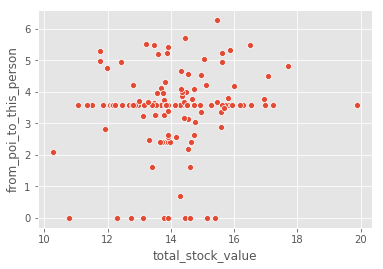

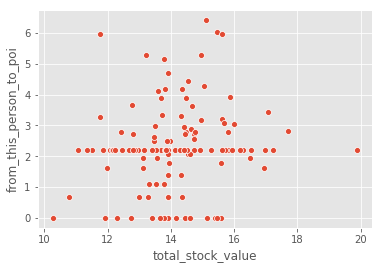

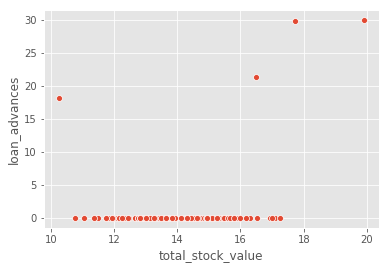

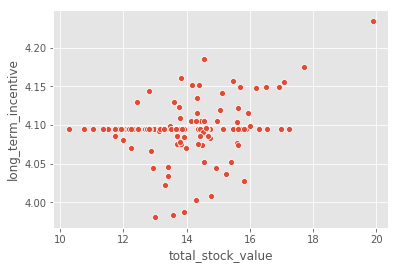

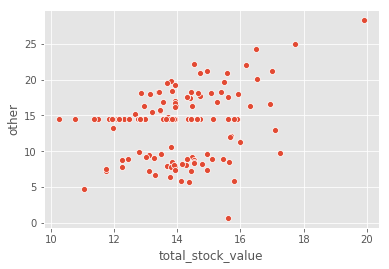

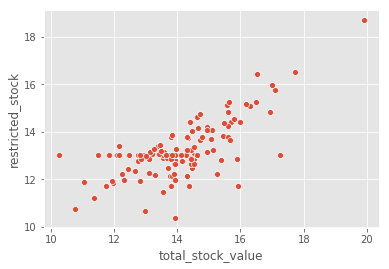

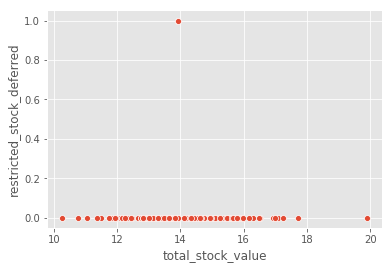

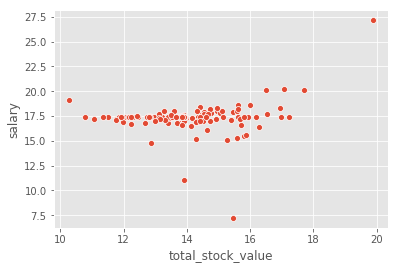

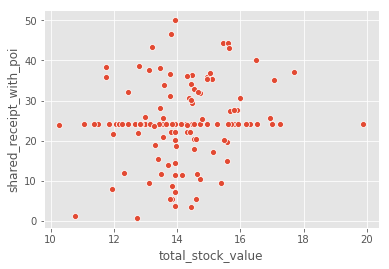

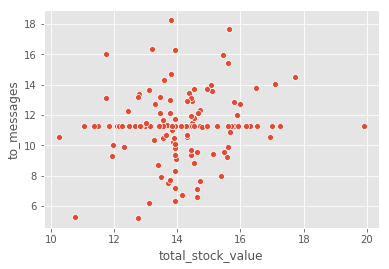

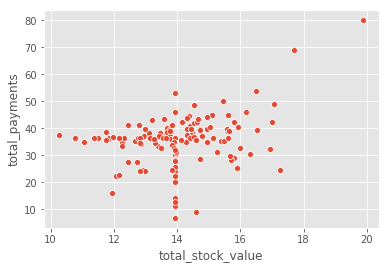

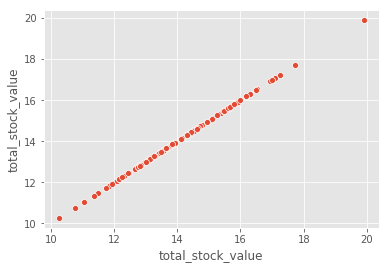

In [160]:
for col in num_features:
    for _col in num_features:
        plt.xlabel(col)
        plt.ylabel(_col)
        sns.scatterplot(df[col], df[_col])
        plt.show()

In [151]:
df["deferred_income"] = -df["deferred_income"]
box_cox_transform = []
log_transform = []
for col in num_features:
    try:
        lam_range = np.linspace(-2,5,100)  # default nums=50
        llf = np.zeros(lam_range.shape, dtype=float)
        _col = np.array(df[col])
        for i,lam in enumerate(lam_range):
            llf[i] = boxcox_llf(lam, _col[~np.isnan(_col)]) # y 必須>0
        # find the max lgo-likelihood(llf) index and decide the lambda
        lam_best = lam_range[llf.argmax()]
        df[col] = boxcox(df[col], lmbda=lam_best)
        box_cox_transform.append(col)        
    except:
        df[col] = np.log1p(df[col])
        log_transform.append(col)

In [152]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data)
    return missing_data
missing_data = na_check(df)

Missing Ratio
restricted_stock_deferred      98.620690
loan_advances                  97.241379
director_fees                  88.275862
deferral_payments              73.793103
deferred_income                66.206897
long_term_incentive            54.482759
bonus                          43.448276
from_messages                  40.689655
from_poi_to_this_person        40.689655
from_this_person_to_poi        40.689655
shared_receipt_with_poi        40.689655
to_messages                    40.689655
other                          36.551724
expenses                       34.482759
salary                         34.482759
exercised_stock_options        29.655172
restricted_stock               24.827586
email_address                  23.448276
total_payments                 14.482759
total_stock_value              13.793103

In [153]:
# 部分欄位缺值填補 0, (missing ratio 大於50%)
zero_cols = list(missing_data[missing_data["Missing Ratio"] > 80].index)
for col in zero_cols:
    df[col] = df[col].fillna(0)
    #df[col] = df[col].fillna(df[col].quantile(0.5))

In [154]:
# 部分欄位缺值填補 中位數(q2), (missing ratio 小於50%)
q2_cols = list(missing_data[(missing_data["Missing Ratio"] <= 80)].index)
q2_cols.remove("email_address")
for col in q2_cols:
    # df[col] = df[col].fillna(0) 補中位數的效果好很多
    df[col] = df[col].fillna(df[col].quantile(0.5))

In [155]:
# email欄位填補None
none_cols = ["email_address"]
for col in none_cols:
    df[col] = df[col].fillna("None")

In [156]:
# 檢查缺失值是否填補完成
missing_data = na_check(df)

Empty DataFrame
Columns: [Missing Ratio]
Index: []

In [157]:
category_transform = ["restricted_stock_deferred", "director_fees"]
for col in category_transform:
    df.loc[df[col] != 0, col] = 1

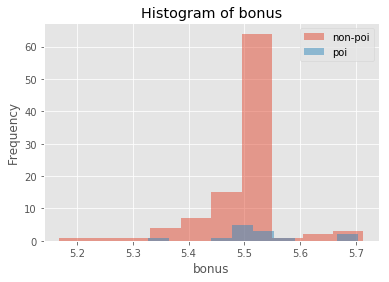

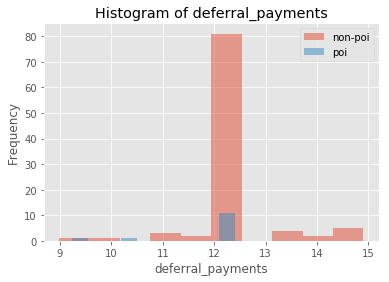

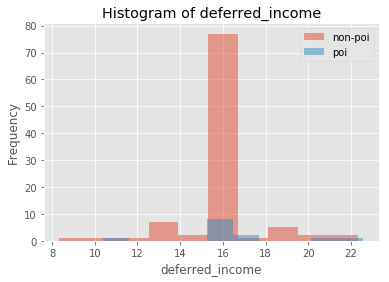

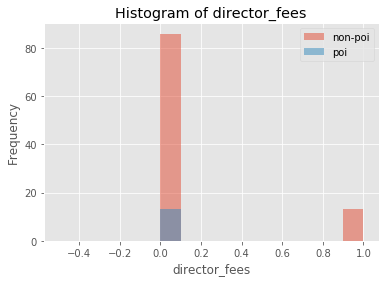

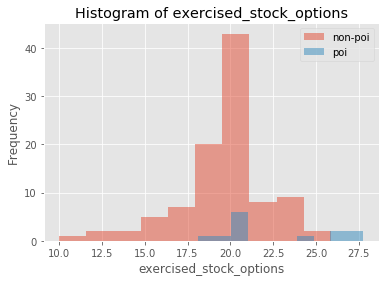

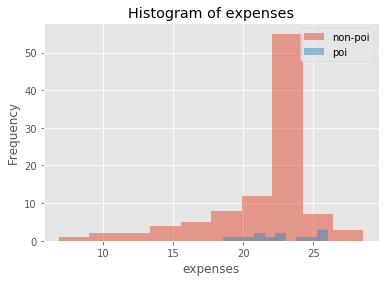

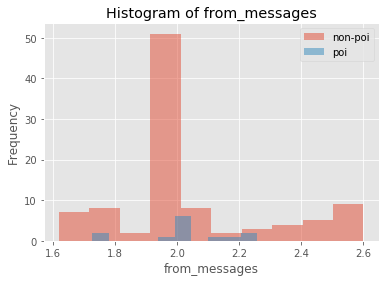

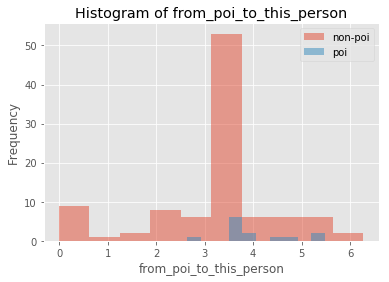

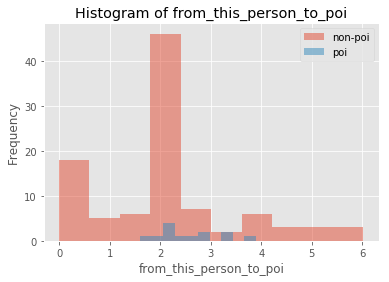

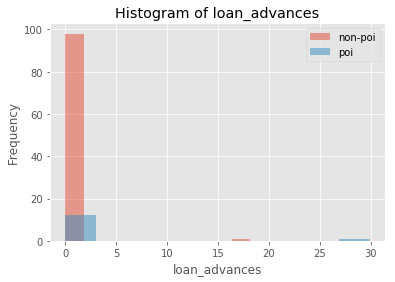

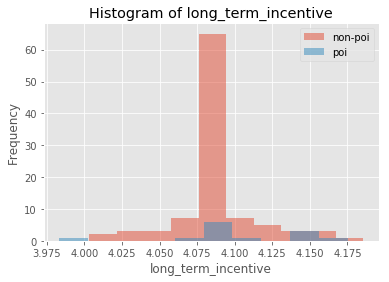

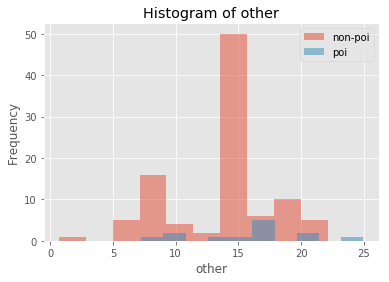

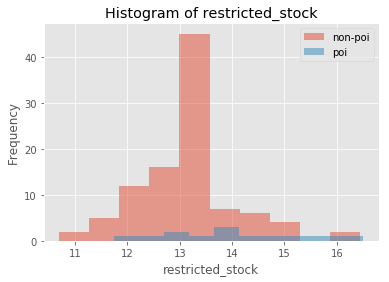

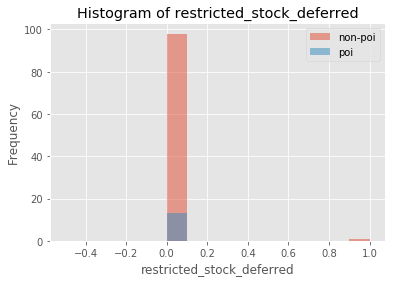

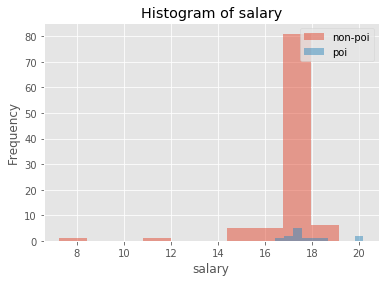

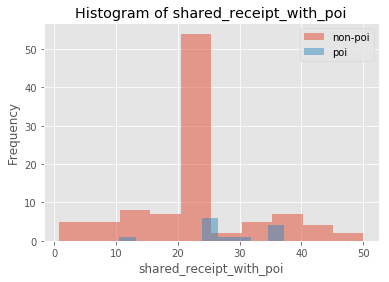

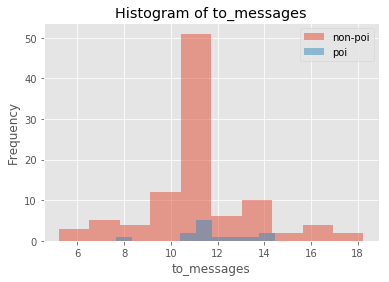

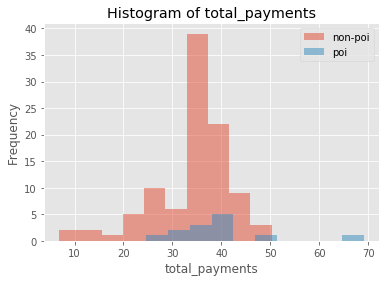

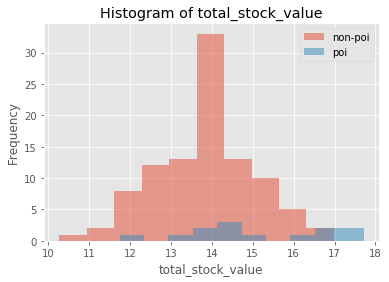

In [158]:
df_hist = pd.concat([df, train_Y], axis=1)
for col in num_features:
    try:
        plt.hist(df_hist[df_hist['poi']==0][col], 10, alpha=0.5, label='non-poi')
        plt.hist(df_hist[df_hist['poi']==1][col], 10, alpha=0.5, label='poi')
        plt.legend(loc='upper right')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title('Histogram of {}'.format(col))
        plt.show()
    except:
        print("**error:{}".format(col))

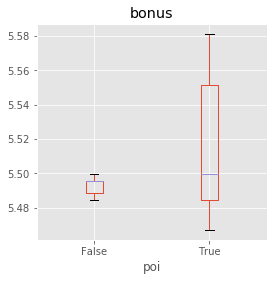

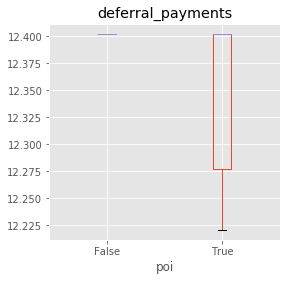

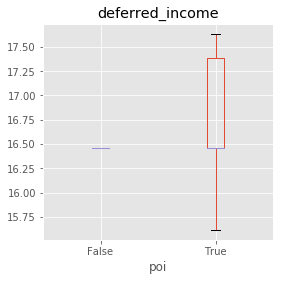

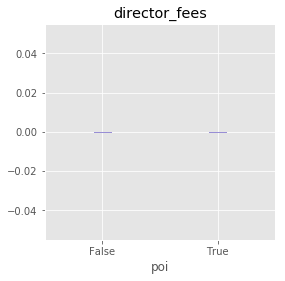

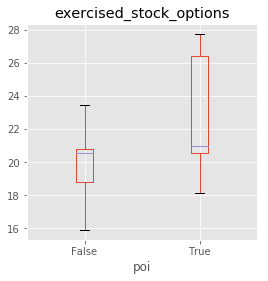

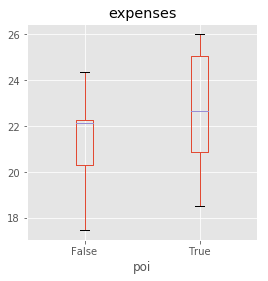

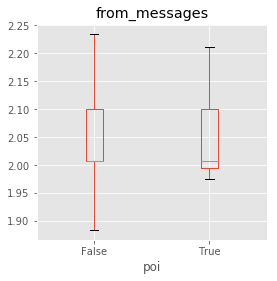

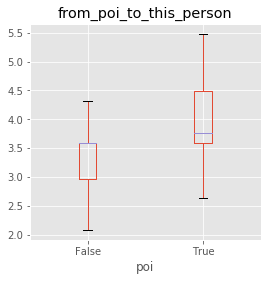

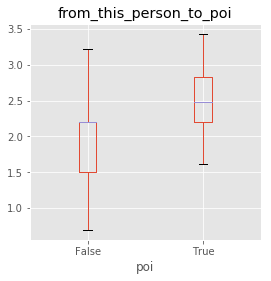

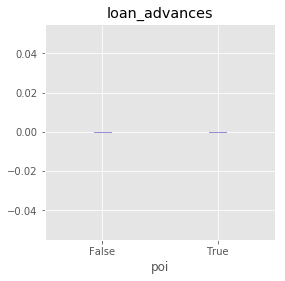

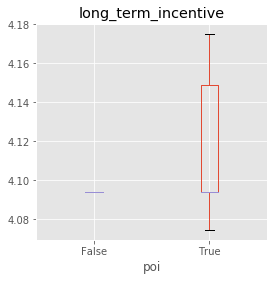

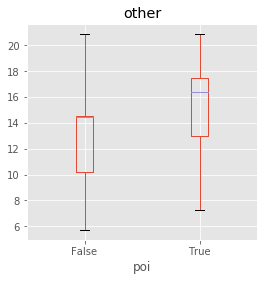

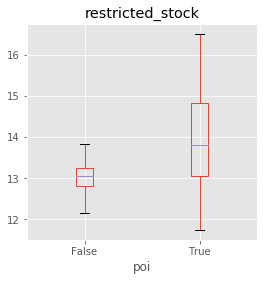

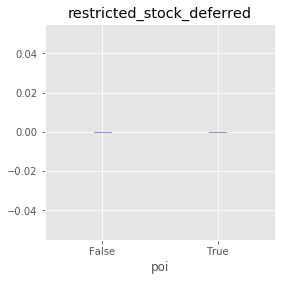

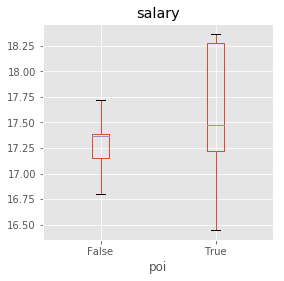

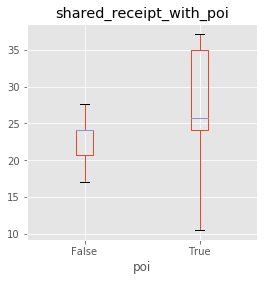

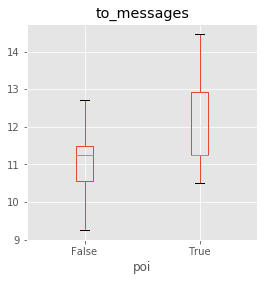

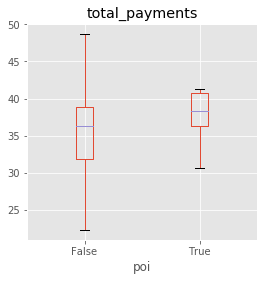

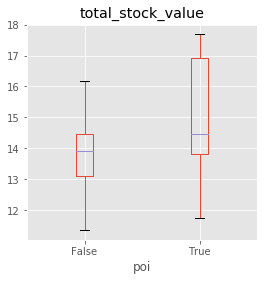

In [159]:
# 觀察每個數值的箱型圖分布 (以目標值去groupby)
for col in num_features:
    df_hist.boxplot(column=col, by = "poi", showfliers = False, figsize=(4,4))
    plt.suptitle('')
    plt.show()

In [54]:
for col in num_features:
    print(col)
    print(df_hist.groupby("poi")[col].sum())
    print("\n")

bonus
poi
False    548.365506
True      71.865587
Name: bonus, dtype: float64


deferral_payments
poi
False    1245.028669
True      155.581342
Name: deferral_payments, dtype: float64


deferred_income
poi
False    1627.524849
True      219.283060
Name: deferred_income, dtype: float64


director_fees
poi
False    13.0
True      0.0
Name: director_fees, dtype: float64


exercised_stock_options
poi
False    1975.659295
True      293.957443
Name: exercised_stock_options, dtype: float64


expenses
poi
False    2105.76352
True      295.10555
Name: expenses, dtype: float64


from_messages
poi
False    205.006985
True      26.225324
Name: from_messages, dtype: float64


from_poi_to_this_person
poi
False    325.886307
True      52.369160
Name: from_poi_to_this_person, dtype: float64


from_this_person_to_poi
poi
False    211.302130
True      33.726909
Name: from_this_person_to_poi, dtype: float64


loan_advances
poi
False    18.183722
True     29.885004
Name: loan_advances, dtype: float64


lo

In [162]:
skwed_feats = df[num_features].apply(lambda x: skew(x.dropna()))#skwed_feats 偏度特征
print(skwed_feats)
#skwed_feats = skwed_feats[skwed_feats>0.75].index # 选取大于0.75的,别忘了取索引
# print('under 0.75', skwed_feats)
# df = pd.get_dummies(data=df,dummy_na=True)# get_dummies转化离散标签为数值标签,别忘了左边添加all_data
# # df = df.fillna(df.mean())# 这一步对all_data的缺失项填补mean值以避免下一步log1p报错（NAN）
#df[skwed_feats] = np.log1p(df[skwed_feats])# log1p处理，注意:开始我等式左边写成了all_data，导致all_data的数据长度变成了(2919,22)
#df = df.fillna(df.mean())# 这一步对all_data的缺失项填补mean值以避免下一步log1p报错（NAN）
# print(df.shape)
# df.head(2)

bonus                        0.043704
deferral_payments            0.827895
deferred_income              0.335736
director_fees                2.379543
exercised_stock_options      0.151796
expenses                     0.395061
from_messages                0.713065
from_poi_to_this_person     -1.158712
from_this_person_to_poi      0.497951
loan_advances                6.141760
long_term_incentive         -0.151908
other                       -0.011810
restricted_stock             1.234250
restricted_stock_deferred    8.337505
salary                      -0.627341
shared_receipt_with_poi     -0.063618
to_messages                  0.065940
total_payments               0.376604
total_stock_value            0.495444
dtype: float64


In [163]:
# 建立新特徵
df["to_poi_ratio"] = df["from_poi_to_this_person"] / df["to_messages"]

In [ ]:
# 策略: 對缺失值高於50% 以上的欄位, 去看其相關性, 如果相關性跟缺失值小於50%的很高的話
# 就把缺失值小於50%的欄位進行cut後, 去groupby產生新的feeature

In [ ]:
print("大於50%缺失值:{}".format(zero_cols))
print("小於50%缺失值:{}".format(q2_cols))

In [ ]:
for col in zero_cols:
    df_corr = pd.DataFrame(df.corr()[col].sort_values())
    a = list(df_corr[((df_corr[col] > 0.9) | (df_corr[col] < -0.9))].index)
    ret = list(set(a).intersection(set(q2_cols)))
    print("欄位{} 與 欄位 {} 最相關".format(col, ret))

In [169]:
# 處理outlier (使用tukey fence)
def outliers_iqr(df, col):
    q1, q3 = np.percentile(df[col], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    df.loc[df[col] < lower_bound, col ] = lower_bound
    df.loc[df[col] > upper_bound, col ] = upper_bound
    #return np.where((data > upper_bound) | (data < lower_bound))

In [170]:
df_remove_outlier = df.copy()
for col in df_remove_outlier[num_features].columns:
    outliers_iqr(df_remove_outlier, col)

In [ ]:
# 觀察每個feature的分布
for col in df_remove_outlier[num_features].columns:
    plt.xlabel("{}".format(col))
    df_remove_outlier[col].hist()
    plt.show()

In [164]:
# 將有無email轉換成bool的新欄位
df["bool_email"] = np.nan
df.loc[df.email_address.isnull(), "bool_email"] = 0
df.loc[df.email_address.notnull(), "bool_email"] = 1

In [165]:
df_train = df.drop(["name", "email_address"], axis=1)

In [173]:
# 把訓練資料跟測試資料切開
train_num = train_Y.shape[0]
train_X = df_train[:train_num]
test_X = df_train[train_num:]
mini_train_X, mini_test_X, mini_train_y, mini_test_y = train_test_split(train_X, train_Y, test_size = 0.25, random_state = 44, stratify=train_Y)

In [174]:
# from sklearn.feature_selection import SelectKBest, chi2, f_classif
# train_X_new = SelectKBest(f_classif, k=15).fit_transform(train_X, train_Y)

In [182]:
# base estimator (沒有處理outlier)
# (80/20 + 調整skew) 0.8845849802371542
lr = LogisticRegression()
# lr.fit(mini_train_X, mini_train_y)
# y_pred = lr.predict(mini_test_X)
# acc = metrics.accuracy_score(y_true=mini_test_y, y_pred=y_pred)
# print("Accuracy: ", acc)
print(cross_val_score(lr, train_X, train_Y, cv=5, scoring="recall").mean())
print(cross_val_score(lr, train_X, train_Y, cv=5, scoring="precision").mean())
print(cross_val_score(lr, train_X, train_Y, cv=5, scoring="accuracy").mean())

0.26666666666666666
0.4666666666666666
0.8837191793713532


In [171]:
df_train_remove_outlier = df_remove_outlier.drop(["name", "email_address"], axis=1)
# 把訓練資料跟測試資料切開
train_num = train_Y.shape[0]
train_X = df_train_remove_outlier[:train_num]
test_X = df_train_remove_outlier[train_num:]
mini_train_X, mini_test_X, mini_train_y, mini_test_y = train_test_split(train_X, train_Y, test_size = 0.25, random_state = 44, stratify=train_Y)

In [172]:
# base estimator (處理outlier)
# (80/20) 調整skew 0.8849802371541502
lr = LogisticRegression()
# lr.fit(mini_train_X, mini_train_y)
# y_pred = lr.predict(mini_test_X)
# acc = metrics.accuracy_score(y_true=mini_test_y, y_pred=y_pred)
# print("Accuracy: ", acc)
print(cross_val_score(lr, train_X, train_Y, cv=5, scoring="recall").mean())
print(cross_val_score(lr, train_X, train_Y, cv=5, scoring="precision").mean())

0.13333333333333333
0.4


In [176]:
lr = LogisticRegression()
#lr = LogisticRegression(tol=0.001, penalty='l2', fit_intercept=True, C=1.0)
gdbt = GradientBoostingClassifier(tol=100, subsample=0.75, n_estimators=250, max_features=20,
                                  max_depth=6, learning_rate=0.03)
rf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, 
                            max_features='sqrt', max_depth=6, bootstrap=True)

In [183]:
for estimator in [lr, gdbt, rf]:
#     estimator.fit(mini_train_X, mini_train_y)
#     y_pred = estimator.predict(mini_test_X)
#     acc = metrics.accuracy_score(y_true=mini_test_y, y_pred=y_pred)
#     print("Accuracy: ", acc)
    print(cross_val_score(estimator, train_X, train_Y, cv=5, scoring="recall").mean())
    print(cross_val_score(estimator, train_X, train_Y, cv=5, scoring="precision").mean())
    print(cross_val_score(estimator, train_X, train_Y, cv=5, scoring="accuracy").mean())
"""
outlier(80/20)
Accuracy:  0.8620689655172413
Accuracy:  0.896551724137931
Accuracy:  0.896551724137931

without outlier(80/20)
Accuracy:  0.9310344827586207
Accuracy:  0.7931034482758621
Accuracy:  0.896551724137931

"""

0.26666666666666666
0.4666666666666666
0.8837191793713532
0.13333333333333333
0.4
0.8928100884622625
0.13333333333333333
0.4
0.8841144362883494


'\noutlier(80/20)\nAccuracy:  0.8620689655172413\nAccuracy:  0.896551724137931\nAccuracy:  0.896551724137931\n\nwithout outlier(80/20)\nAccuracy:  0.9310344827586207\nAccuracy:  0.7931034482758621\nAccuracy:  0.896551724137931\n\n'

In [184]:
# stacking
from mlxtend.classifier import StackingClassifier

meta_estimator = GradientBoostingClassifier(tol=100, subsample=0.70, n_estimators=50, 
                                           max_features='sqrt', max_depth=4, learning_rate=0.3)
"""
Your Code Here
"""
stacking = StackingClassifier(classifiers=[lr, gdbt, rf],
                             use_probas=True,
                             average_probas=False,
                             meta_classifier=meta_estimator)

# stacking.fit(mini_train_X, mini_train_y)
# y_pred = stacking.predict(mini_test_X)
# acc = metrics.accuracy_score(y_true=mini_test_y, y_pred=y_pred)
# print("Accuracy: ", acc)
print(cross_val_score(stacking, train_X, train_Y, cv=5, scoring="recall").mean())
print(cross_val_score(stacking, train_X, train_Y, cv=5, scoring="precision").mean())
print(cross_val_score(stacking, train_X, train_Y, cv=5, scoring="accuracy").mean())

0.13333333333333333
0.4
0.8928100884622625


In [179]:
lr.fit(train_X, train_Y)
lr_pred = lr.predict_proba(test_X)[:, 1]
sub = pd.DataFrame({'name': df_test["name"], 'poi': lr_pred})
sub.to_csv('enron_lr.csv', index=False)

In [70]:
gdbt.fit(train_X, train_Y)
gdbt_pred = gdbt.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': df_test["name"], 'poi': gdbt_pred})
sub.to_csv('enron_gdbt.csv', index=False)

In [48]:
#rf.fit(train_X, train_Y)
rf_pred = rf.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': df_test["name"], 'poi': rf_pred})
sub.to_csv('enron_rf_2.csv', index=False)

In [181]:
stacking.fit(train_X, train_Y)
stacking_pred = stacking.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': df_test["name"], 'poi': stacking_pred})
sub.to_csv('enron_stacking.csv', index=False)

In [ ]:
# pipeline
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler, Normalizer

# must redefine params to fit the pipeline
knn_params = {'imputer__strategy':['mean', 'median'],
              "tol":[0.0001, 0.001], }
knn = KNeighborsClassifier()  # instantiate a KNN model
mean_impute_standardize = Pipeline([('imputer', Imputer()), ('standardize', Normalizer()), ('classify', lr)])
#mean_impute = Pipeline([('imputer', Imputer(strategy='mean')), ('classify', knn)])

X = train_X
y = train_Y

grid = GridSearchCV(mean_impute_standardize, knn_params)
grid.fit(X, y)

print (grid.best_score_, grid.best_params_)

In [ ]:
# grid_pred = grid.predict_proba(test_X)[:, 1]
# sub = pd.DataFrame({'name': df_test["name"], 'poi': grid_pred})
# sub.to_csv('enron_grid.csv', index=False)